In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan

import ogle as o #module

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

summ = pd.read_csv('summtab.csv')
alls = pd.read_csv('allsummtab.csv')

cross['Part'] = 1
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
cross2['Part'] = 2

In [2]:
# alls.to_csv('allsummtab.csv')

# Find Base
- function from SuperorbitalFeatures.ipynb
- three discrete answers; can compare to other method
    - individually quantify by getting stdev of min and max using n chunks

In [2]:
mlist2 = ['OII I','OIII I','OIV I']
mlist1 = ['OII I','OIII I']

In [3]:
def findbase(srcn,iband=[],vband=[],plot=True,cut=100,diff=0.1,frac=False,printall=False,perc=0,checkog=True):
    '''percentile used instead of maximum and minimum; must be greater than 50
    if frac: use diff as fraction of range rather than magnitudes
    checkog: check that base points are in all OGLE epochs '''
    if len(iband)==0:
        try: ilist, vlist = o.getIV(srcn,cross,stack=False,plot=plot,mlist=mlist1)
        except: ilist, vlist = o.getIV(srcn,cross2,stack=False,plot=plot,mlist=mlist2)
        iband,vband = vstack(ilist),vstack(vlist)
    #identify minimum and maximum points
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    if frac:
        #window for points near max or min is fraction of range
        #if overall low variability, window smaller
        diff = (maxi-mini)*diff
    if perc>0: #using the percentage to keep away from weird/wrong outliers
        maxi = np.median(iband['I mag'])+scipy.stats.iqr(iband['I mag'], rng=[50,perc])
        mini = np.median(iband['I mag'])-scipy.stats.iqr(iband['I mag'], rng=[(100-perc),50])
    #filter table to points within 0.1 mags (to do: or do fractional?) of max and min
    minf = iband[iband['I mag']<=mini+diff]
    maxf = iband[iband['I mag']>=maxi-diff]
    
    #at least cut more points near maximum (faintest)
    if len(maxf)>len(minf)+cut:
        #make sure maximum points exist in all OGLE epochs
        go = True
        if checkog: 
            for i in ilist:
                tmaxf = i[i['I mag']>=maxi-diff]
                #in no points in an epoch, sets to undetermined
                if len(tmaxf)==0: go = False
        if go:
            if printall: print(f'{srcn}: base at faintest')
            elif plot: plt.text(6500,mini+(maxi-mini)/2,'base at faintest')
            return 'base at faintest'
        else:
            if printall: print(f'{srcn}: undetermined or no base')
            elif plot: plt.text(6500,mini+(maxi-mini)/2,'undetermined or no base')
            return 'undetermined or no base'
    elif len(minf)>len(maxf)+cut:
        go = True
        if checkog: 
            for i in ilist:
                tminf = i[i['I mag']<=mini+diff]
                #in no points in an epoch, sets to undetermined
                if len(tminf)==0: go = False
        if go:
            if printall: print(f'{srcn}: base at brightest')
            elif plot: plt.text(6500,mini+(maxi-mini)/2,'base at brightest')
            return 'base at brightest'
        else:
            if printall: print(f'{srcn}: undetermined or no base')
            elif plot: plt.text(6500,mini+(maxi-mini)/2,'undetermined or no base')
            return 'undetermined or no base'
    else: 
        if printall: print(f'{srcn}: undetermined or no base')
        elif plot: plt.text(6500,mini+(maxi-mini)/2,'undetermined or no base')
        return 'undetermined or no base'

In [4]:
srcns = alls['src_n']
srcns = sorted(srcns) #in order

go through 20 sources at a time and check how the results look

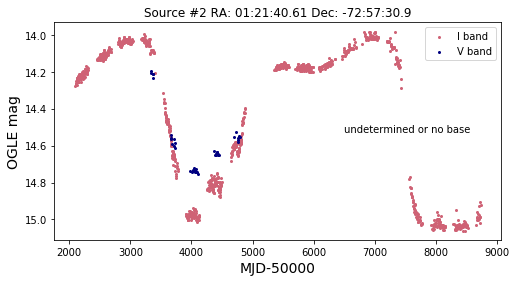

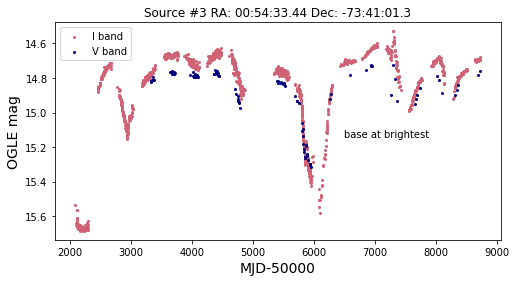

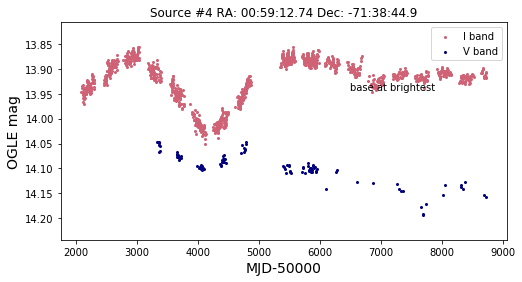

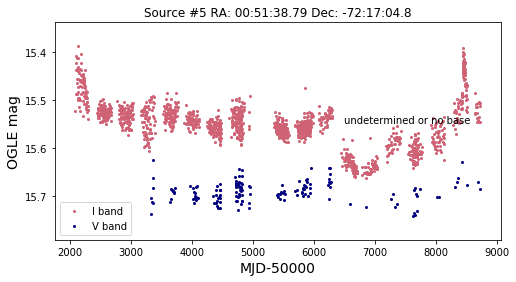

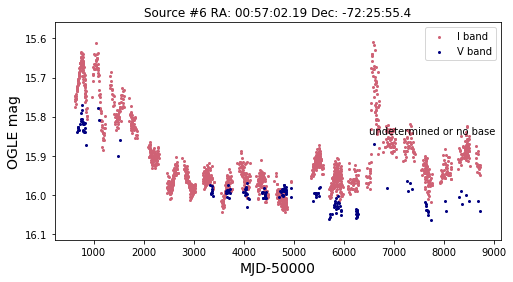

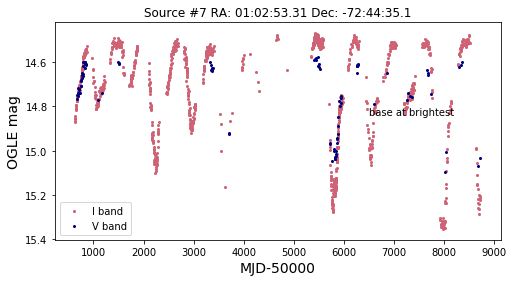

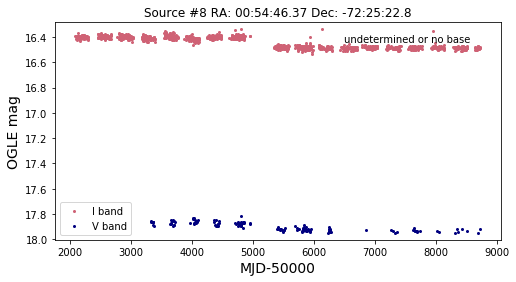

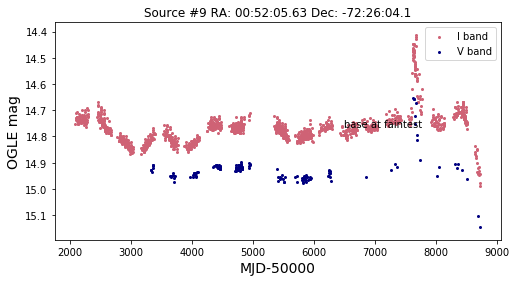

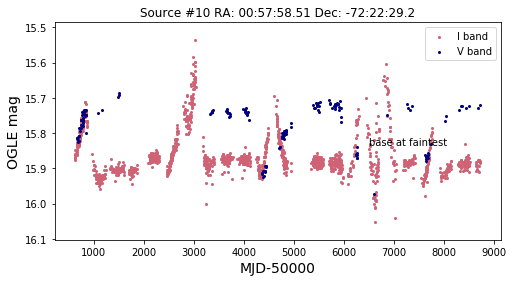

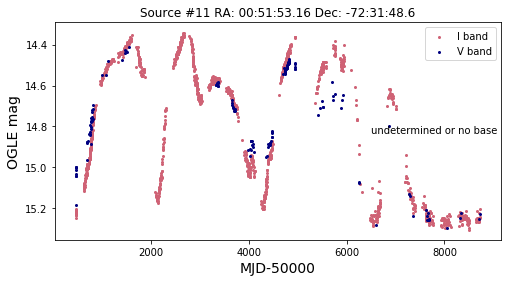

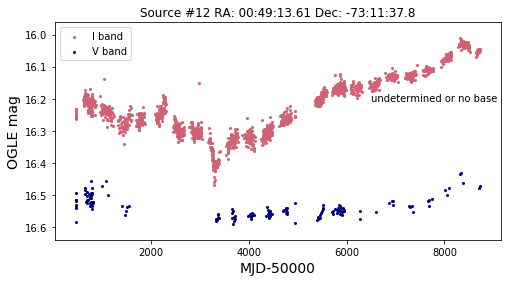

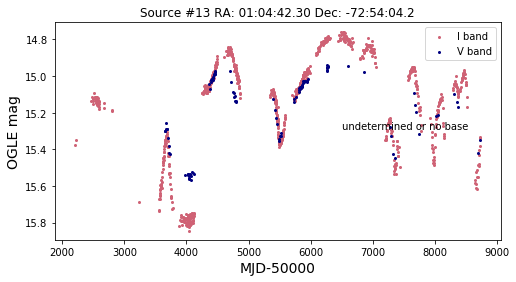

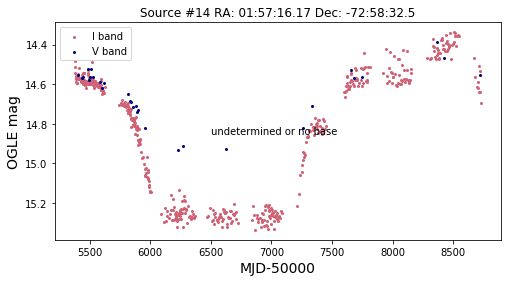

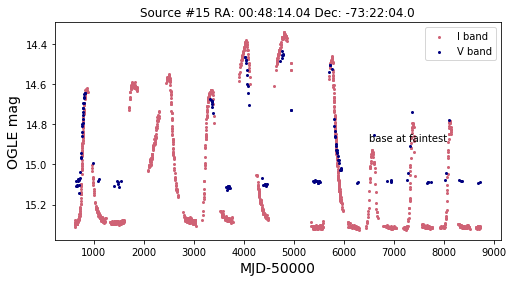

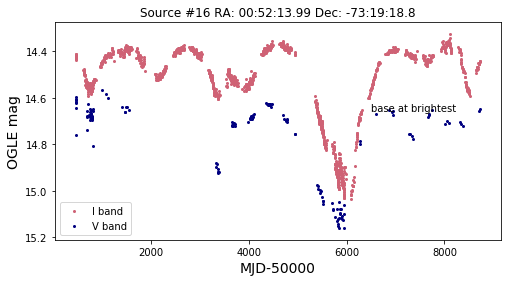

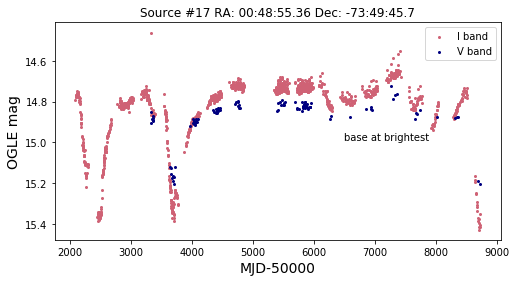

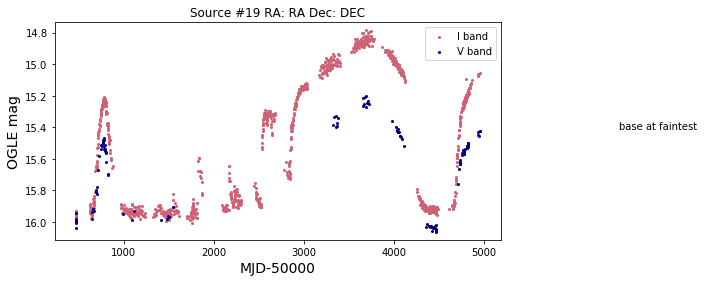

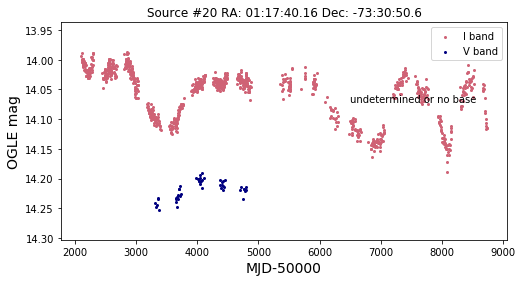

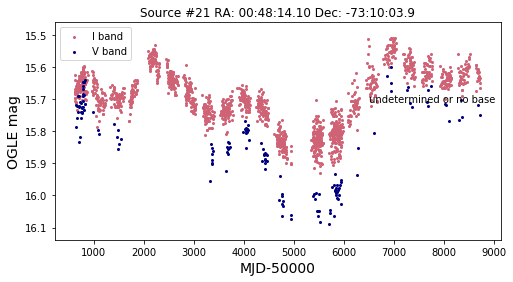

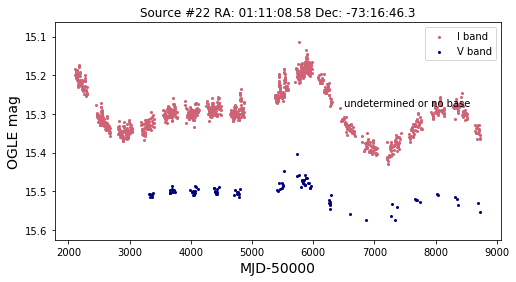

In [5]:
#list of base states
bases = []
for s in srcns[:20]:
    b = findbase(s,perc=95,cut=200,frac=True)
    bases.append(b)

empty file for OIII I


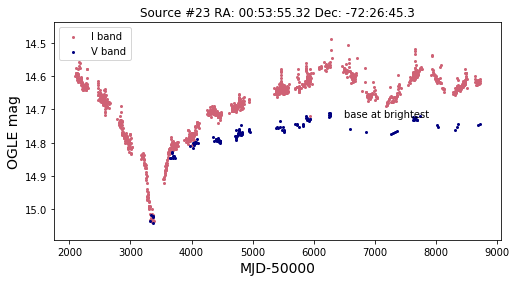

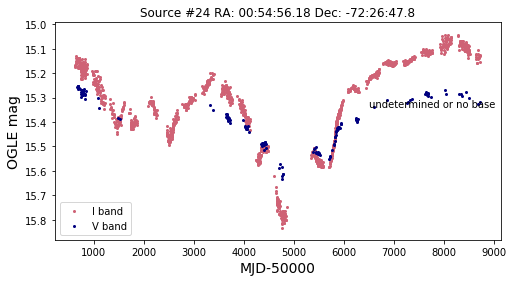

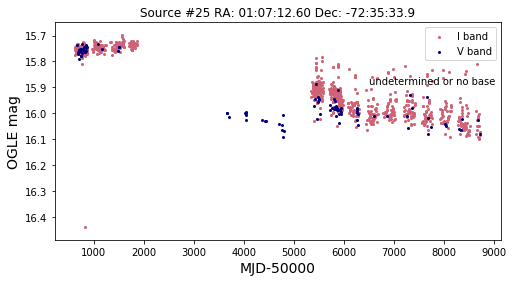

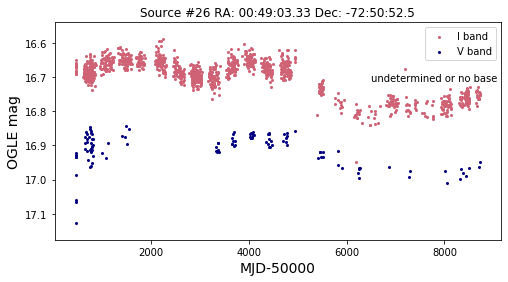

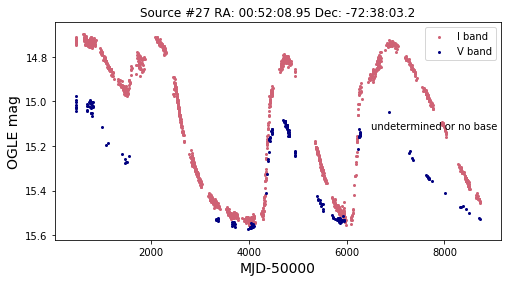

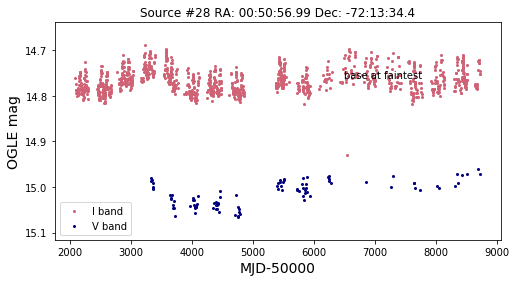

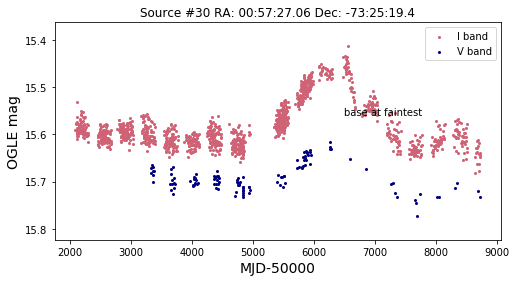

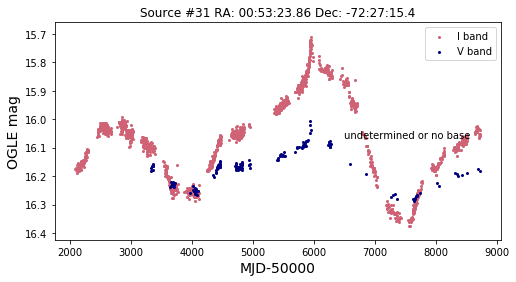

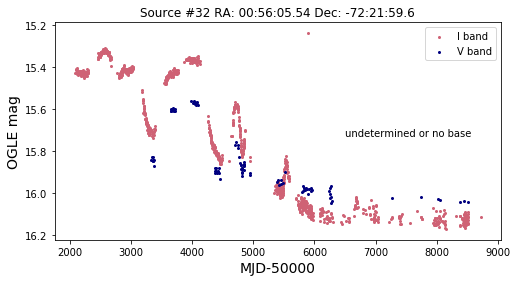

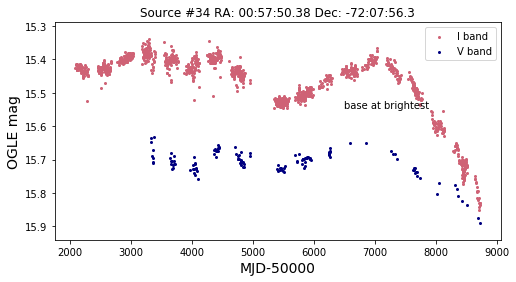

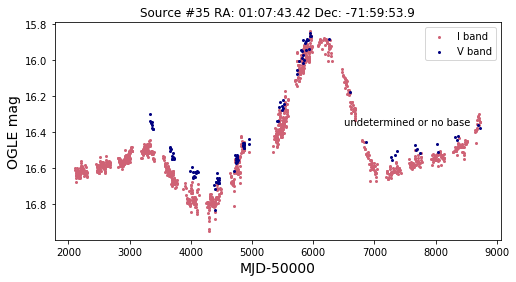

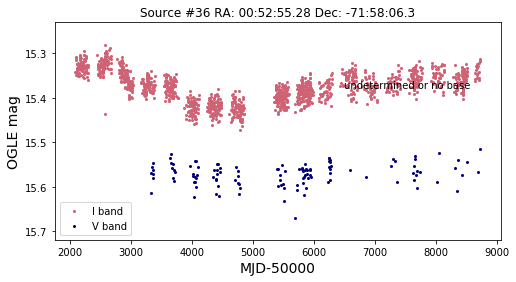

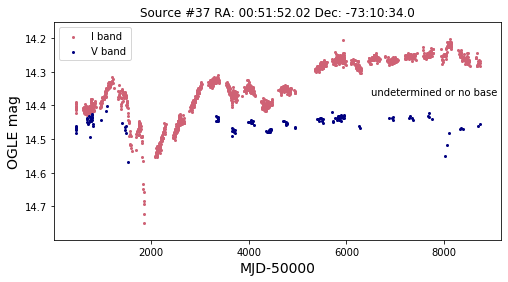

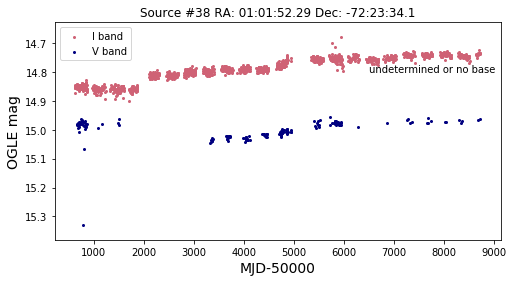

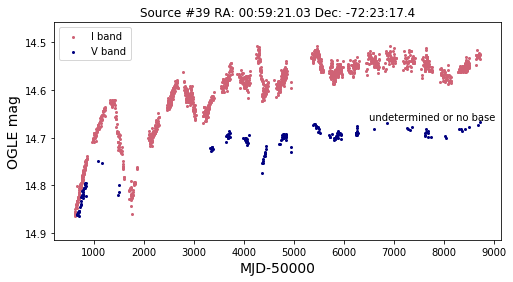

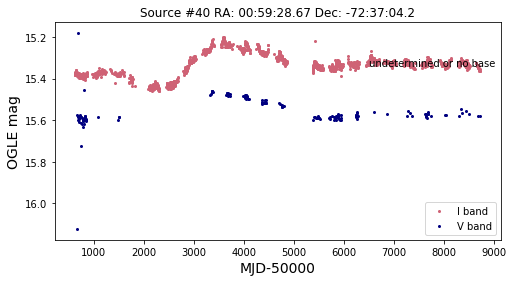

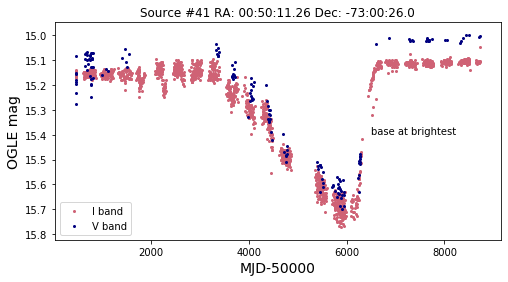

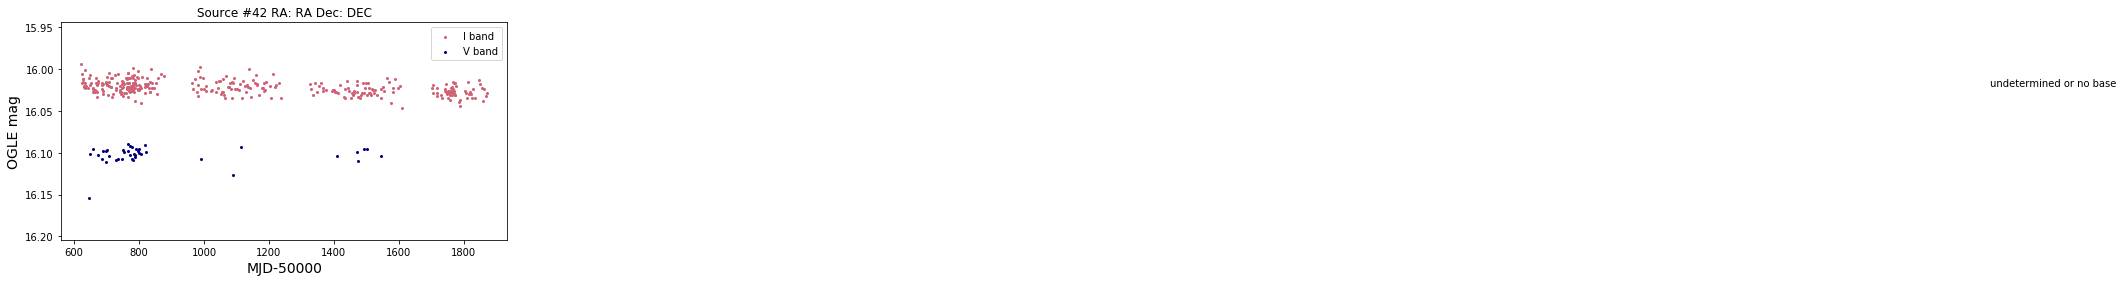

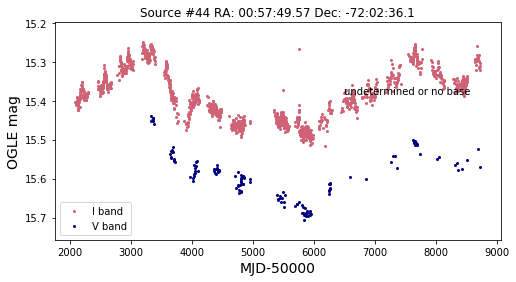

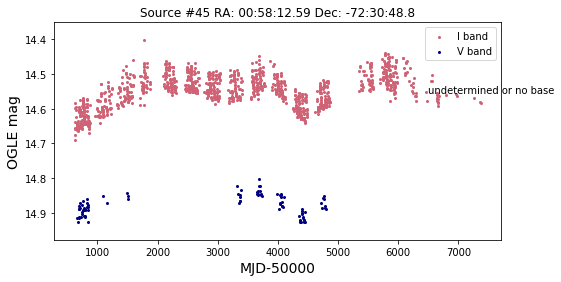

In [26]:
for s in srcns[20:40]:
    b = findbase(s,perc=95,cut=200,frac=True)
    bases.append(b)

In [27]:
len(bases)

40

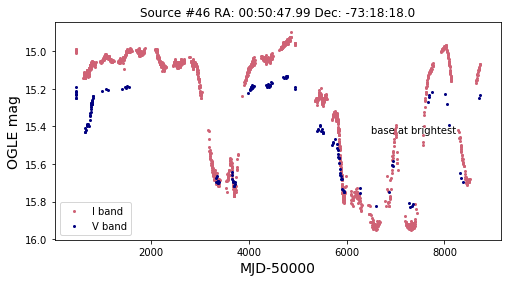

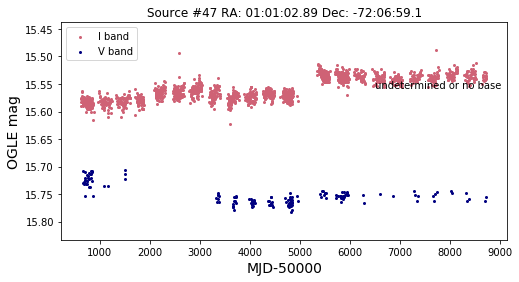

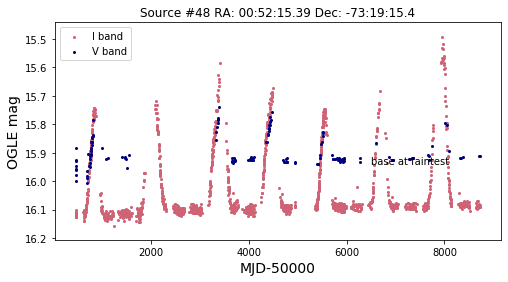

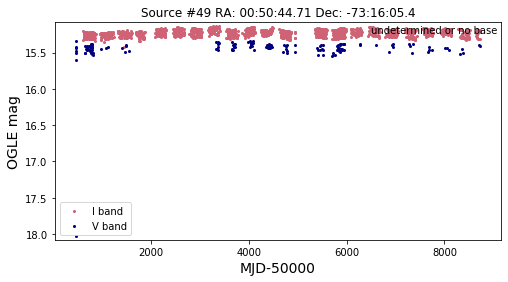

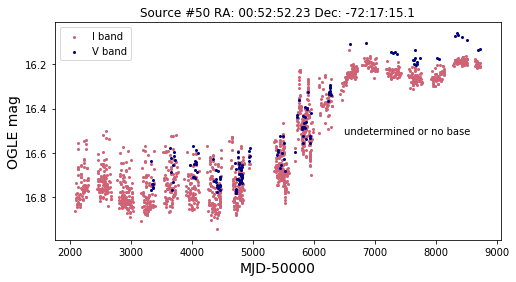

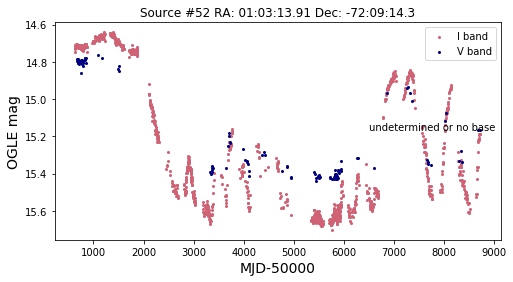

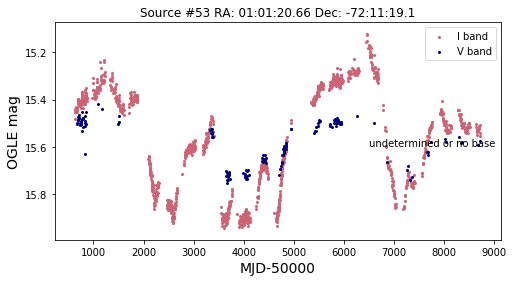

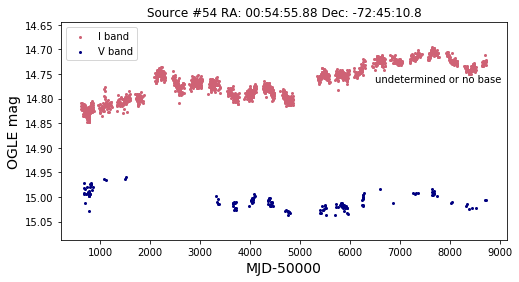

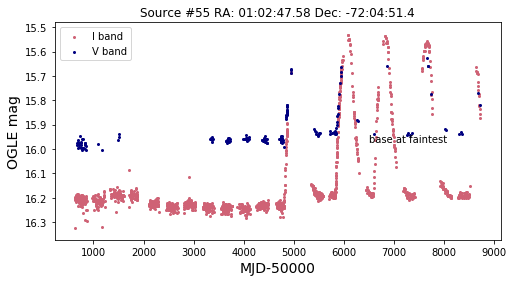

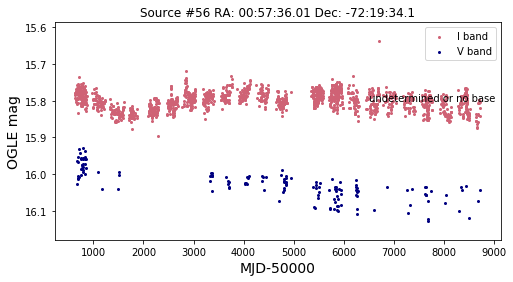

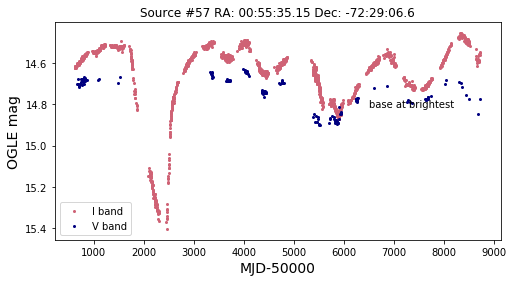

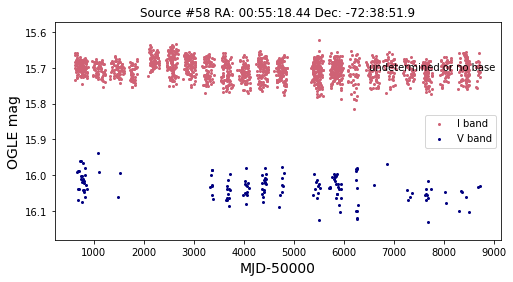

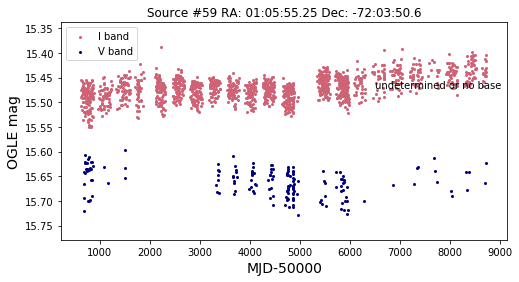

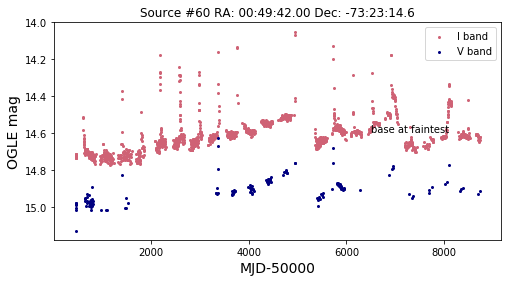

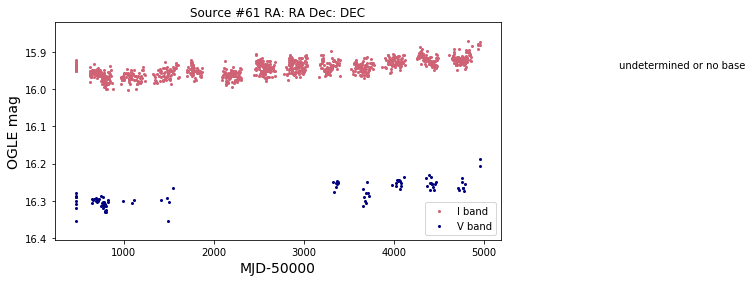

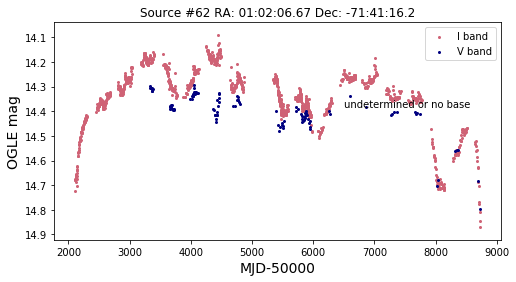

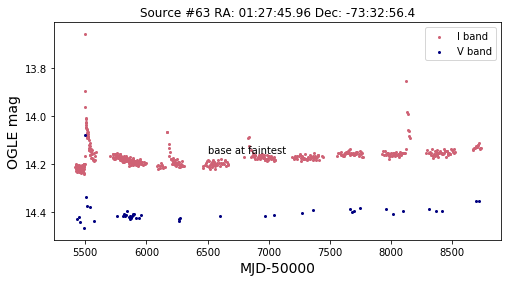

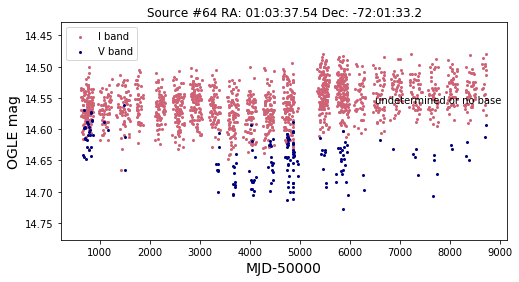

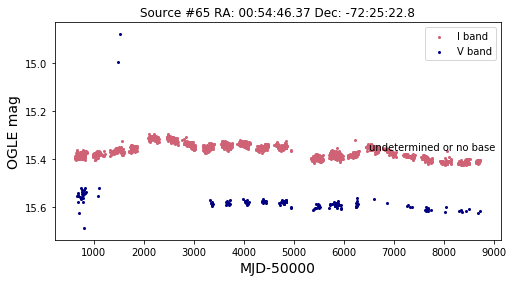

In [28]:
for s in srcns[40:60]:
    try: b = findbase(s,perc=95,cut=200,frac=True)
    except: b = 'N/A'
    bases.append(b)

empty file for OII I


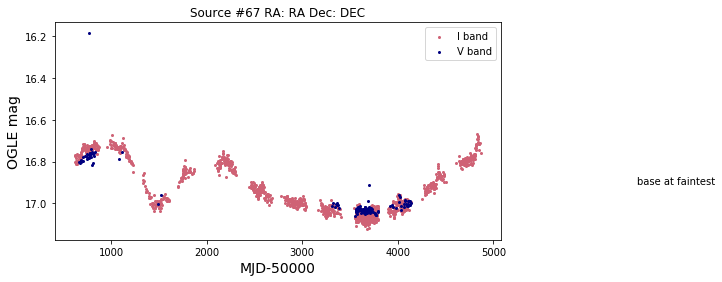

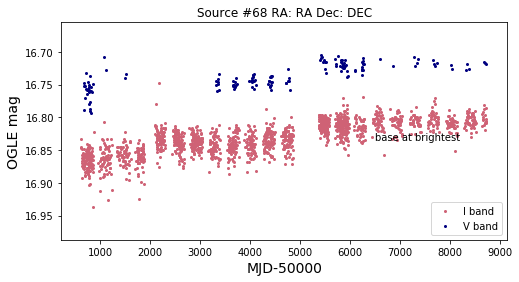

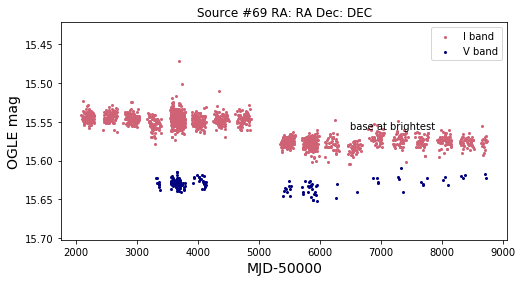

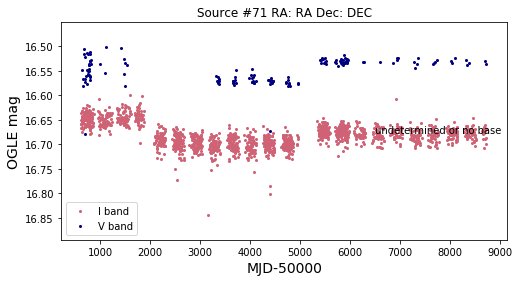

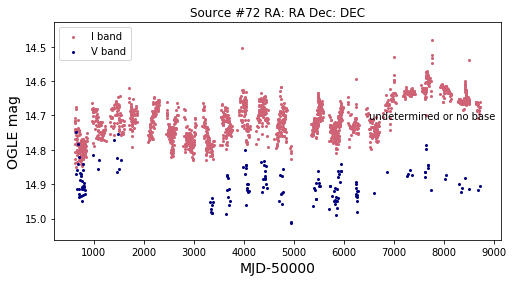

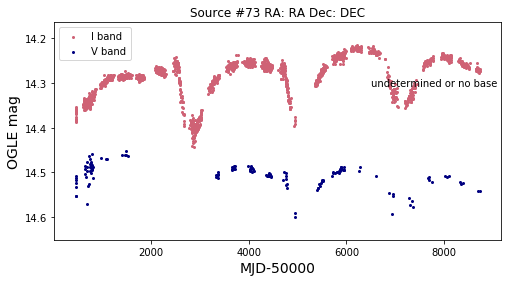

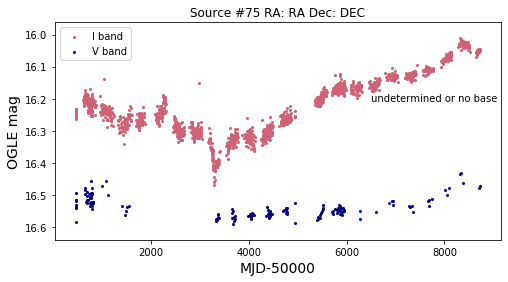

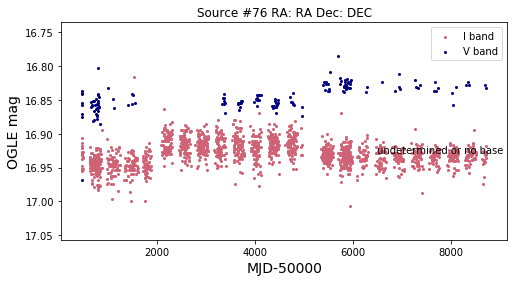

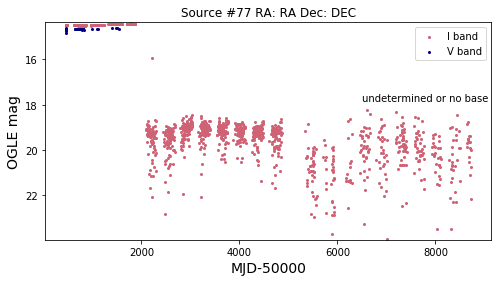

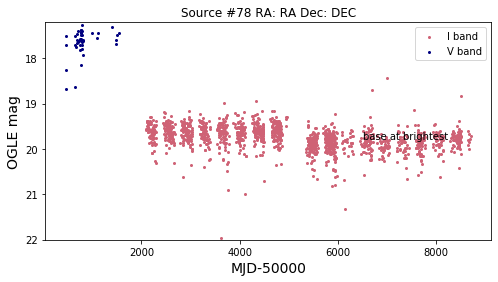

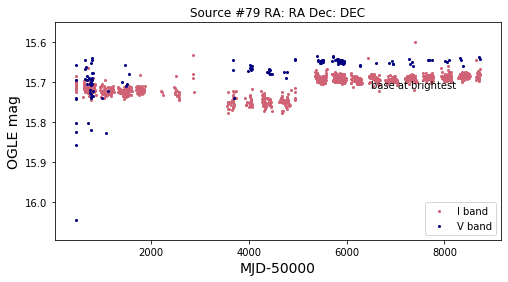

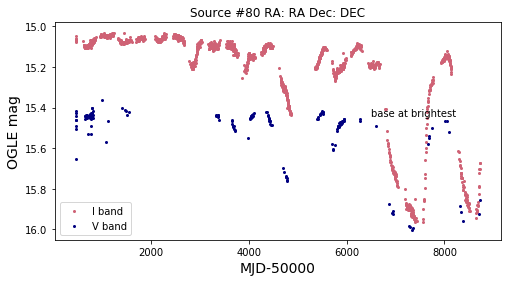

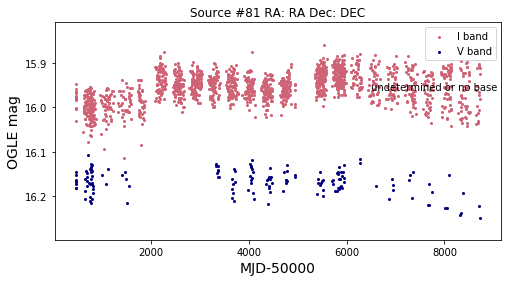

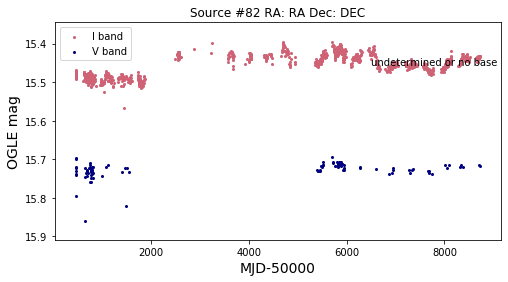

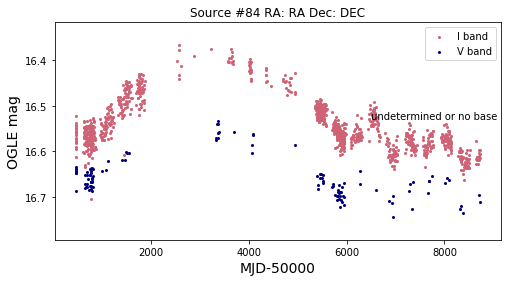

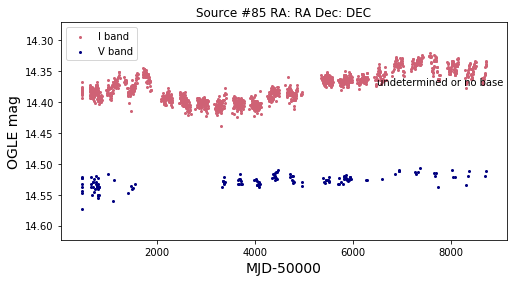

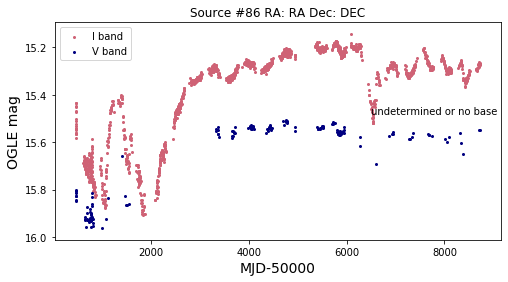

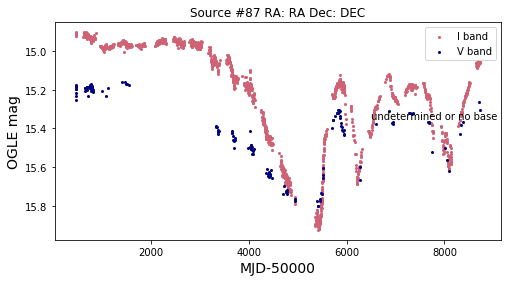

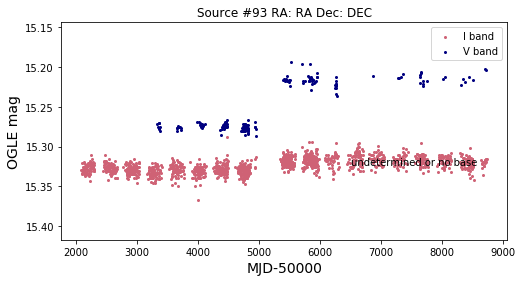

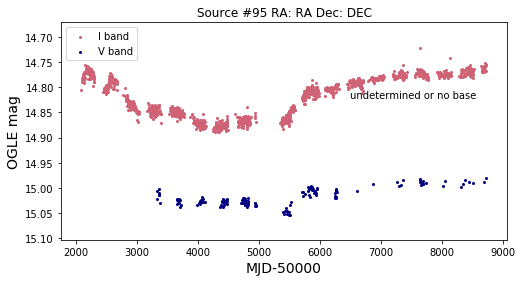

In [31]:
for s in srcns[60:80]:
    try: b = findbase(s,perc=95,cut=200,frac=True)
    except: b = 'N/A'
    bases.append(b)

empty file for OIII I


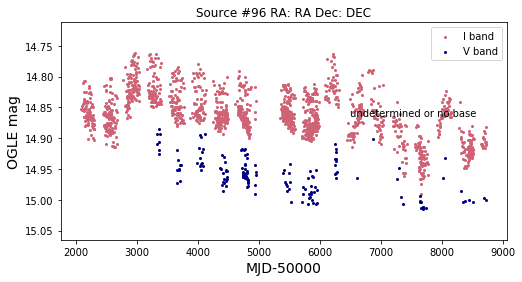

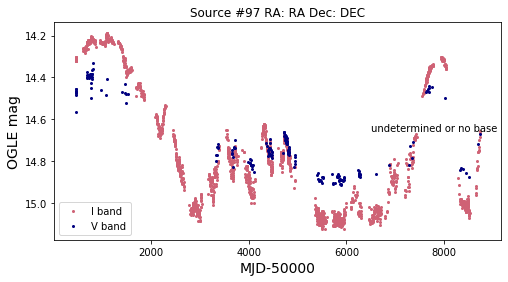

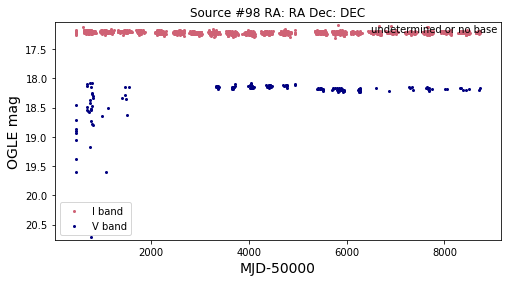

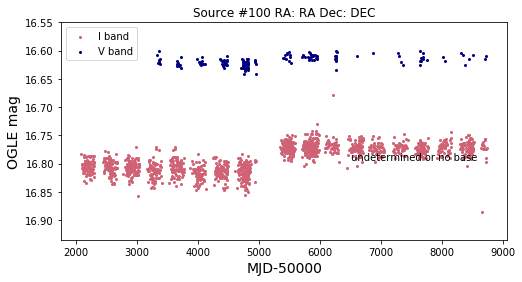

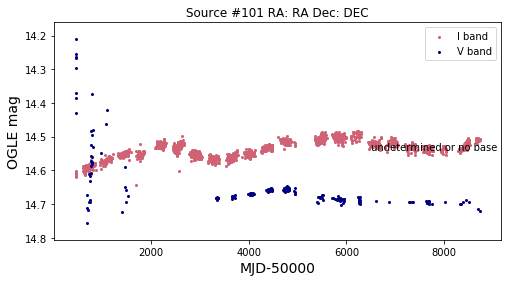

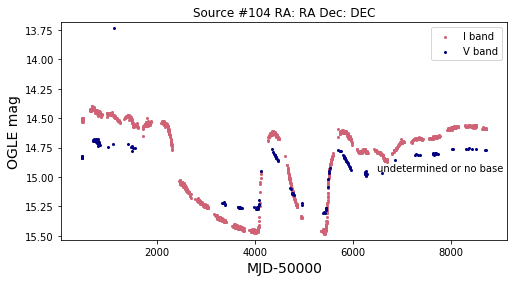

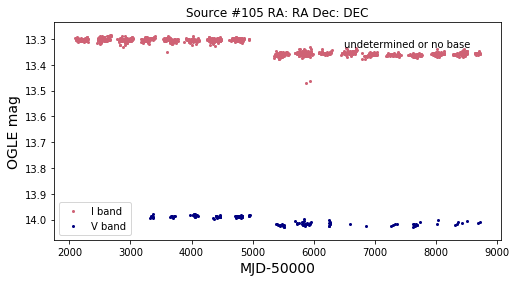

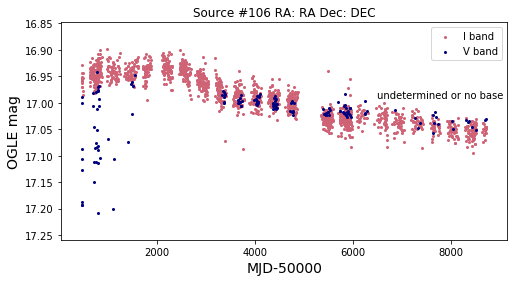

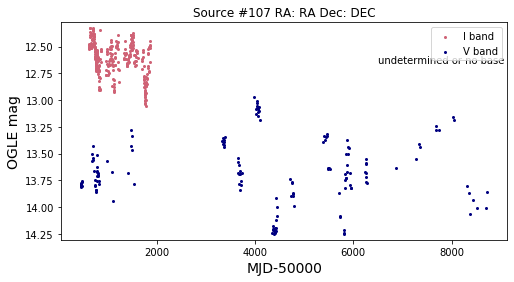

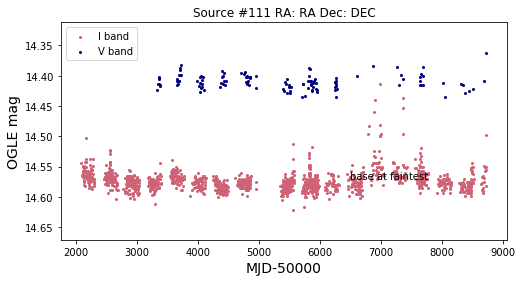

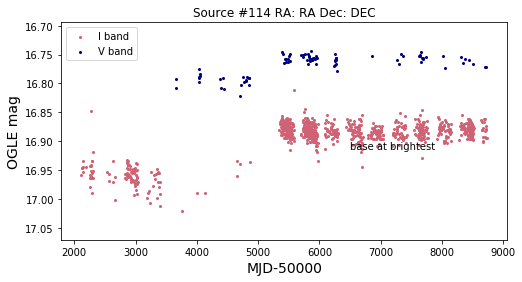

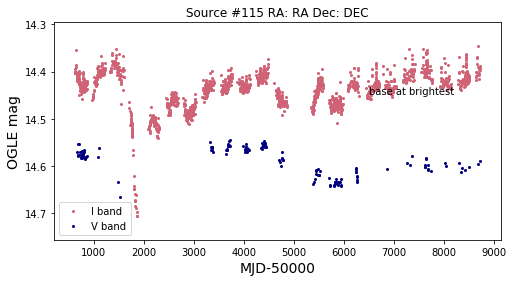

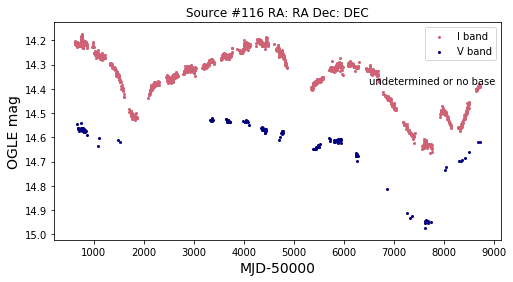

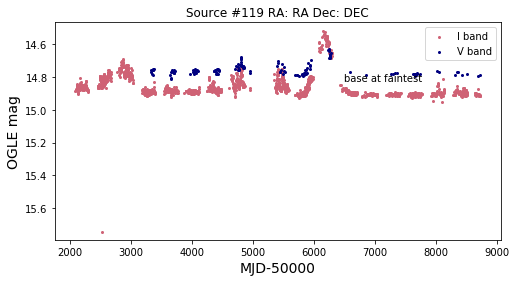

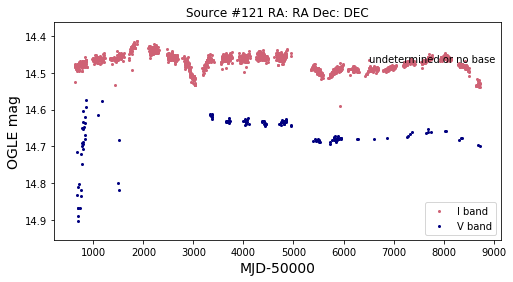

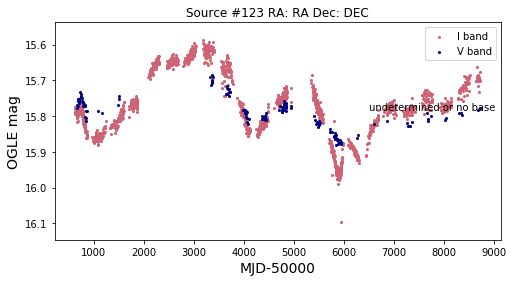

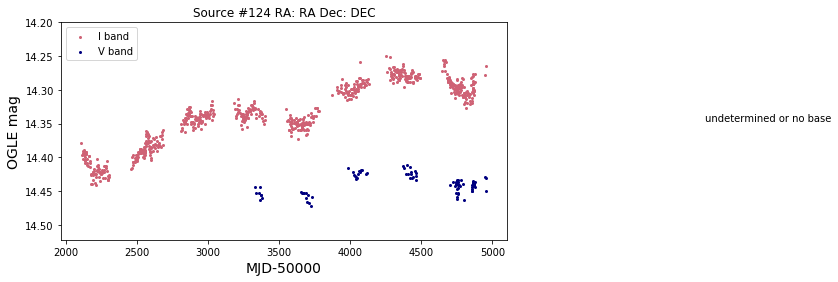

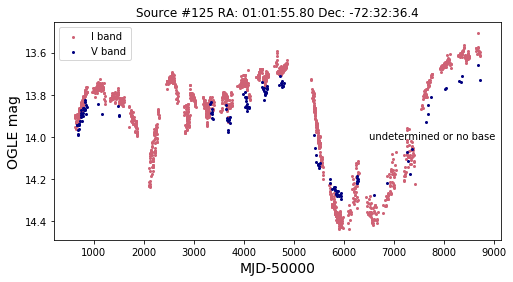

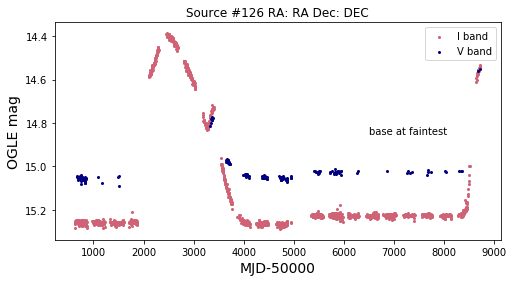

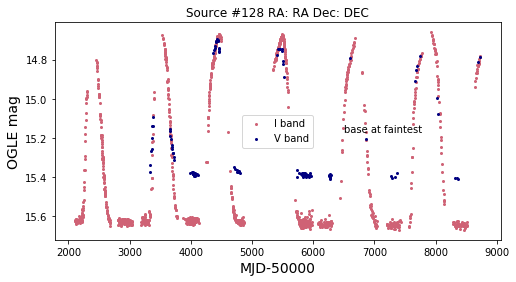

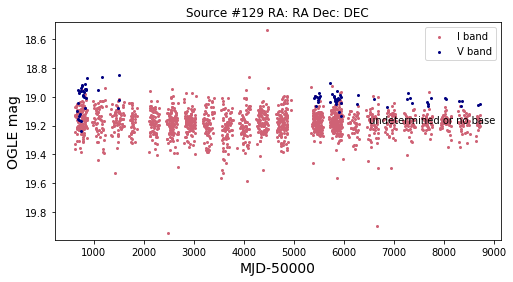

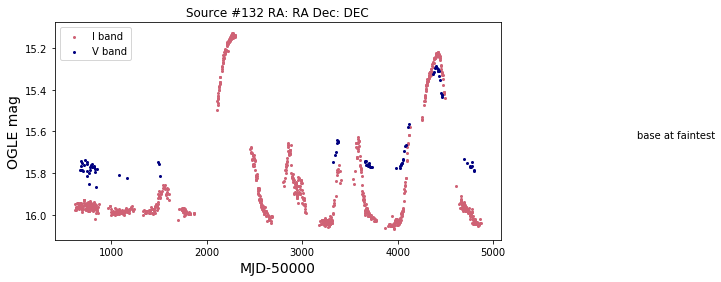

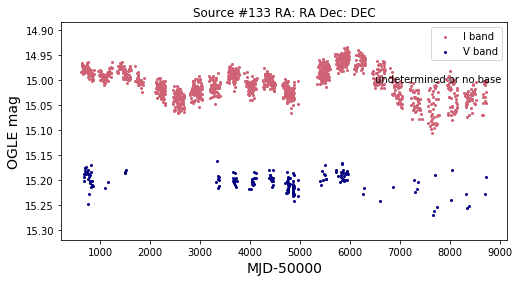

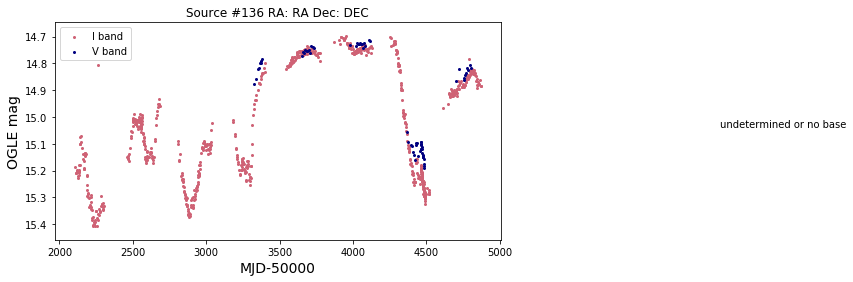

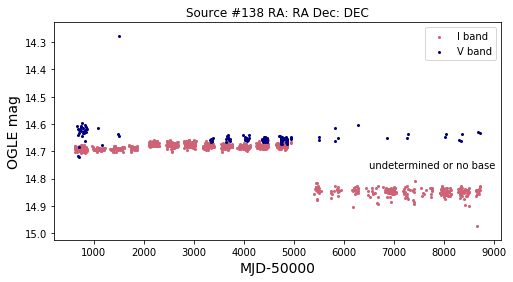

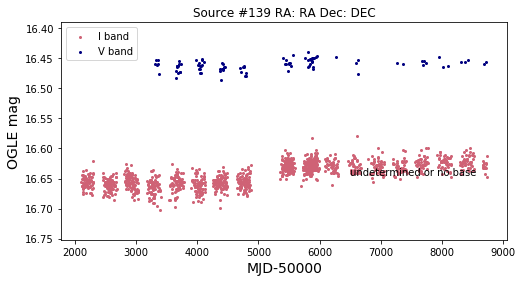

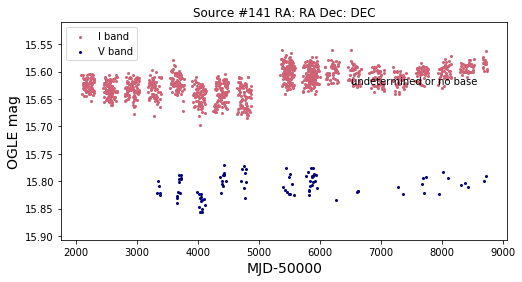

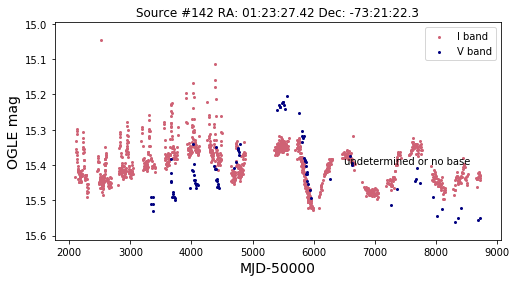

In [32]:
for s in srcns[80:]:
    try: b = findbase(s,perc=95,cut=200,frac=True)
    except: b = 'N/A'
    bases.append(b)

In [36]:
alls['base string'] = bases

In [39]:
alls['base string'][:5]

0    undetermined or no base
1          base at brightest
2          base at brightest
3    undetermined or no base
4    undetermined or no base
Name: base string, dtype: object

In [40]:
for a in range(len(alls)):
    if alls.loc[a]['base string']=='base at brightest':
        print(alls.loc[a]['type'])

3
3
2
3
2
3
3+6
3
4
3
8
8
8
7
4
8
3


base at brightest are type 2,3,4, or quiescent (7 and 8)
- 2 is type 1 but flipped, so it's right to have base at brightest
- 3 and 4 are also right b/c they have bright base w/ dips
- don't really want quiescent to get a base
- below, go the other way to see if these types have base at brightest
- both 2 are determined base at brightest
- many of 3 and 4 are undetermined
    - *justification of quantifying on continuous scale*
    

In [87]:
btest = []
for s in srcns:
    try: b = findbase(s,perc=99,cut=100,diff=0.2,frac=True,plot=False)
    except: b = 'N/A'
    btest.append(b)

empty file for OIII I
empty file for OII I
empty file for OIII I


In [59]:
def twocol(ifc='type',thenc='base string',value='2',tab=alls):
    for a in range(len(alls)):
        if tab.loc[a][ifc]==value:
            print(tab.loc[a][thenc])

In [90]:
alt = alls.copy()
alt['base 2'] = btest
twocol(ifc='type',thenc='base 2',value='5',tab=alt)

undetermined or no base
undetermined or no base
base at brightest
undetermined or no base
base at faintest
undetermined or no base
base at faintest
undetermined or no base
base at brightest
base at faintest
undetermined or no base
undetermined or no base
base at brightest
undetermined or no base
base at brightest
base at brightest
undetermined or no base


In [52]:
twocol(ifc='type',thenc='base string',value='3')

base at brightest
base at brightest
base at brightest
undetermined or no base
base at brightest
undetermined or no base
undetermined or no base
base at brightest
base at brightest
base at brightest
undetermined or no base


In [53]:
twocol(ifc='type',thenc='base string',value='2')

base at brightest
undetermined or no base
base at brightest
undetermined or no base
base at brightest
base at brightest
undetermined or no base
undetermined or no base
undetermined or no base


In [56]:
#this will help in big dip -- no type 5 are base at brightest
twocol(ifc='type',thenc='base string',value='5')

undetermined or no base
undetermined or no base
undetermined or no base
undetermined or no base
undetermined or no base
undetermined or no base
undetermined or no base
undetermined or no base
undetermined or no base
base at faintest
undetermined or no base
undetermined or no base
undetermined or no base
undetermined or no base
undetermined or no base
undetermined or no base
undetermined or no base


In [48]:
#repeat for faintest
twocol(ifc='base string',thenc='type',value='base at faintest')

5
1+?
1
1+6
7
1+6
1
1
5
5
6
7
1+7
1
1
1


base at brightest are by-eye type 1, 5, 6, 7
- 1 as intended
- 5 as intended (greatest variability is sharp peaks)
- 6 is "no base state or potential faint base" so okay but cehck those sources
- 7 is ~quiescent, so again not too concerned b/c really they **should be filtered out first**

# Find Base Method 2: min and max stdev using chunks
#### idea: esp. using min and max chunk standard dev, can add category of both bright and faint bases
- latest idea: focus on not global change (stdev) but rather linear (i.e. is there a "completely" different minimum in the final chunks)

In [6]:
#chunk code from ChangingFeatures.ipynb

def cut(srcn,cut=10,npoints=False,time=False,retstd=True,retrange=False,calib=False,plot=True,text=False,statistic='median',glob=False,retsplit=False,window=200): #decide whether to do fixed chunks or fixed factor chunks or fixed number of points
    '''Divide LC into chunks and find median in each
    Division can be by number of points per piece or by total number of pieces.
    cut: number of pieces or number of points per piece or number of days per piece, depending on bool npoints and bool time
    npoints: if True, cut determines (approx) number of points per chunk; if False, cut determines total number of pieces
    time: if True, cut gives number of days included in each chunk
    retstd: return standard deviation of median values
    retrange: return range of median values
    calib: calibrate data by setting the medians of OII,OIII, and OIV to the same
    plot: plot LC
    retsplit: if True, return right after splitting; returns the split days,I mags, and det I lists
    TO DO: CHOOSE BETWEEN ORIGINAL AND DETRENDED
    '''
    #make sure plt.text not used if not plotting
    if not plot: text = False
    if srcn in cross['src_n']:
        c = cross
        mlist = mlist1
    else:
        c = cross2
        mlist = mlist2
    if glob: 
        global iband
        iband = o.getIV(srcn,c,calib=calib,both=False,stack=True,plot=plot,mlist=mlist,printall=False)
    else: iband = o.getIV(srcn,c,calib=calib,both=False,stack=True,plot=plot,mlist=mlist,printall=False)
    #detrend with spline
    flatten,trend = o.splinedetrend(iband,retspline=True,window=window)
    if npoints: cut = int(len(iband)/cut)+1 #number of pieces is length of table divided by number of points in each piece
    #time cut means days per piece, so divide total time by that to get number of pieces
    if time: cut = int((iband['MJD-50000'][-1:]-iband['MJD-50000'][:1])/cut)
    imagsplit = np.array_split(iband['I mag'],cut)
    splinesplit = np.array_split(iband['I detrend'],cut)
    #retsplit means just split up the values and return rather than calculating stat
    if retsplit:
        timesplit = np.array_split(iband['MJD-50000'],cut)
        trendsplit = np.array_split(trend,cut)
        return timesplit,imagsplit,splinesplit,trendsplit
    stats = []
    #TO DO: option to calculate statistic on detrended instead
    for i in range(cut):
        if statistic=='median': stat = np.median(imagsplit[i])
        elif statistic=='mean': stat = np.mean(imagsplit[i])
        elif statistic=='max': stat = np.max(imagsplit[i])
        elif statistic=='min': stat = np.min(imagsplit[i])
        elif statistic=='IQR': stat = scipy.stats.iqr(imagsplit[i])
        elif statistic=='stdev': stat = np.std(imagsplit[i])
        elif statistic=='skew': stat = scipy.stats.skew(imagsplit[i])
        elif statistic=='kurtosis':stat = scipy.stats.kurtosis(imagsplit[i])
        else: print('please enter valid statistic');return
        stats.append(stat)
    #add standard deviation of medians to plot
    if text:
        plt.text(np.median(iband['MJD-50000'])-1000,np.min(iband['I mag'])+.04,f'stdev of {statistic}s of {cut} chunks: {np.std(stats):.2f}')
    if retstd and retrange: return np.std(meds), np.max(meds)-np.min(stats)
    elif retstd: return np.std(stats)
    elif retrange: return p.max(stats)-np.min(stats)
    else: return stats
    

#### latest idea: cut off most max points and fit a line
- then check slope

#### latest idea here

even source 3 is not a clear answer
- people may disagree over whether it has a bright base since it doesn't have a flat one
- may've just thought so because varies much less than dips
- so think about quantifying along a spectrum

for now: see how effective it is to make sure that each of five chunks has point within fifth of total range from absolute minimum

In [33]:
def gettype(num='2',tab=alls):
    typen = []
    for a in range(len(alls)):
        if tab.loc[a]['type']==num:
            typen.append(tab.loc[a]['src_n'])
    return typen

In [34]:
type2 = gettype(num='2')
type3 = gettype(num='3')
type5 = gettype(num='5')

In [185]:
type1 = gettype(num='1')
type4 = gettype(num='4')
type6 = gettype(num='6')
type7 = gettype(num='7')

In [116]:
#those fail but have high skew
frac = 0.25
for t in type2:
    mins = cut(t,cut=4,retstd=False,retrange=False,calib=False,plot=False,text=False,statistic='min',glob=True,retsplit=False,window=200)
    omin = np.min(mins) #overall minimum
    orange = np.max(iband['I mag']) - omin
    mins = np.array(mins)
    cmin = mins[mins<omin+orange*frac] #constant mins
    #if they're not in this range, print the difference
    nmin = mins[mins>omin+orange*frac]
    if len(nmin)>0:
        print((nmin-omin)/orange)
        mag = iband['I mag']
        print(f'skew: {st.skew(mag)}')
        print(f'stdev of mins: {np.std(mins)}')
    else:print(len(cmin))

4
4
[0.27253886]
skew: 1.7880853737007774
stdev of mins: 0.10420412659775032
4
4
4
[0.33727034]
skew: 1.0668974797487891
stdev of mins: 0.0999862490545575
4
4


In [117]:
frac = 0.25
for t in type3:
    mins = cut(t,cut=4,retstd=False,retrange=False,calib=False,plot=False,text=False,statistic='min',glob=True,retsplit=False,window=200)
    omin = np.min(mins) #overall minimum
    orange = np.max(iband['I mag']) - omin
    mins = np.array(mins)
    cmin = mins[mins<omin+orange*frac] #constant mins
    #if they're not in this range, print the difference
    nmin = mins[mins>omin+orange*frac]
    if len(nmin)>0:
        print((nmin-omin)/orange)
        mag = iband['I mag']
        print(f'skew: {st.skew(mag)}')
        print(f'stdev of mins: {np.std(mins)}')
    else:print(len(cmin))

4
4
4
[0.37857143]
skew: 0.2042410798065222
stdev of mins: 0.06218118686548236
[0.30236794]
skew: 1.2255504452425086
stdev of mins: 0.06432145831680094
[0.26202532]
skew: 0.5493164721805999
stdev of mins: 0.07775080385436567
4
[0.2941989]
skew: 1.044556365082594
stdev of mins: 0.08106324691251911
4
4
4


In [121]:
#now want to see skew and stdev for ones that SUCCEED
frac = 0.25
for t in type5:
    mins = cut(t,cut=4,retstd=False,retrange=False,calib=False,plot=False,text=False,statistic='min',glob=True,retsplit=False,window=200)
    omin = np.min(mins) #overall minimum
    orange = np.max(iband['I mag']) - omin
    mins = np.array(mins)
    cmin = mins[mins<omin+orange*frac] #constant mins
    #if they're not in this range, print the difference
    nmin = mins[mins>omin+orange*frac]
#     if len(nmin)>0:
#         print((nmin-omin)/orange)
#     else:
#         print(len(cmin))
    if len(nmin)==0:
        mag = iband['I mag']
        print(f'skew: {st.skew(mag)}')
        print(f'stdev of mins: {np.std(mins)}')
        print(f'source number: {t}')

skew: 0.8517394067033628
stdev of mins: 0.01136606792166956
source number: 26
skew: -0.1673765856415102
stdev of mins: 0.014949916387725906
source number: 44
skew: 1.1409959189840326
stdev of mins: 0.057477713072111476
source number: 62
skew: 0.9129518813704518
stdev of mins: 0.03750333318519867
source number: 116
skew: 0.15377457492246968
stdev of mins: 0.0362792985047953
source number: 123
skew: 0.2819147598191977
stdev of mins: 0.013881192311902022
source number: 133
skew: -0.09882899848136183
stdev of mins: 0.040638651552432535
source number: 136


In [186]:
def typeskew(typen,printall=True):
    diffs = []
    skews = []
    mdiff = []
    for t in typen:
        try: iband, vband = o.getIV(t,cross,stack=True,plot=False,mlist=mlist1,figsize=(4,3))
        except: iband, vband = o.getIV(t,cross2,stack=True,plot=False,mlist=mlist2,figsize=(4,3))
        med = np.median(iband['I mag'])
        maxm = np.max(iband['I mag'])
        minm = np.min(iband['I mag'])
        #difference between difference between max and med, min and med
        diff = (maxm-med)-(med-minm)
        if printall:print(diff)
        diffs.append(diff)
        mdiff.append((med-minm)/np.std(iband['I mag']))
        skew = st.skew(iband['I mag'])
        skews.append(skew)
        if printall:print(f'skew: {skew}')
    return diffs,mdiff,skews

In [183]:
t2diff,t2mdiff,t2skew = typeskew(type2)

0.5020000000000024
skew: 1.011883388736845
0.43900000000000006
skew: 0.9100859182764144
0.3269999999999982
skew: 1.7880853737007774
0.09200000000000053
skew: 0.7900903366950499
0.6310000000000002
skew: 0.8734104213872651
0.7659999999999982
skew: 2.214389490139443
0.4480000000000004
skew: 1.0668974797487891
0.49700000000000166
skew: 0.9403175151593929
0.5329999999999977
skew: 0.6020519470798726


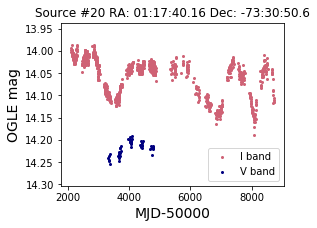

In [132]:
try: iband, vband = o.getIV(type2[3],cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(type2[3],cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [182]:
#many more here that overlap with 5 -- since both types have more variation going on 
t3diff,t3mdiff,t3skew = typeskew(type3)

0.6729999999999983
skew: 1.698965125436025
0.08699999999999974
skew: 1.0619458938664854
0.402000000000001
skew: 1.3742649260847142
0.04399999999999871
skew: 0.2042410798065222
0.20600000000000307
skew: 1.2255504452425086
0.23399999999999999
skew: 0.5493164721805999
0.25399999999999956
skew: 0.643525913603922
0.49599999999999866
skew: 1.044556365082594
0.6379999999999999
skew: 1.9725517968240407
0.1819999999999986
skew: 1.6470310301896853
0.25399999999999956
skew: 0.8416967314208598


In [184]:
t5diff,t5mdiff,t5skew = typeskew(type5)

0.005000000000002558
skew: -0.28702208815096836
-0.04800000000000004
skew: -0.2755649740233944
0.16899999999999693
skew: 0.8517394067033628
-0.0400000000000027
skew: -0.035078931417523725
-0.30400000000000027
skew: -1.0015730560806482
-0.002000000000000668
skew: 0.14655770172494267
-0.015000000000000568
skew: -0.1673765856415102
0.012000000000002231
skew: 0.28624854336420524
0.30100000000000016
skew: 1.1409959189840326
-0.2149999999999963
skew: -0.7385021336283852
0.005000000000002558
skew: -0.28702208815096836
-0.04100000000000037
skew: -0.7782461293381792
0.20099999999999874
skew: 0.9129518813704518
0.1379999999999999
skew: 0.15377457492246968
0.019000000000000128
skew: 0.37054634678694826
0.03700000000000081
skew: 0.2819147598191977
-0.04300000000000104
skew: -0.09882899848136183


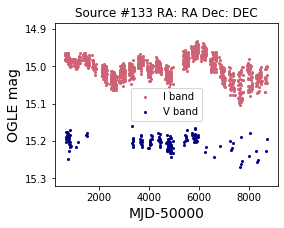

In [125]:
#for this one, may just want amplitude or rel. variability requirement for big dip?
#fairly low skew, but partially b/c no dip
try: iband, vband = o.getIV(133,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(133,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

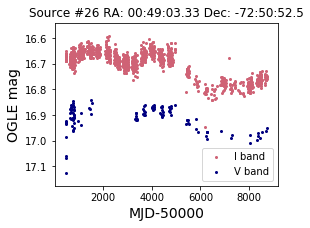

In [107]:
#I agree this one could be mis-typed
try: iband, vband = o.getIV(type5[2],cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(type5[2],cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

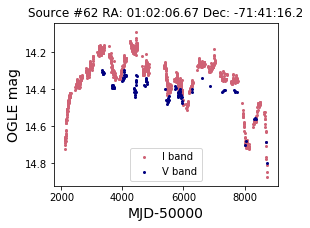

In [108]:
#this one also a boundary case (used to be down for type 2)
try: iband, vband = o.getIV(type5[8],cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(type5[8],cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

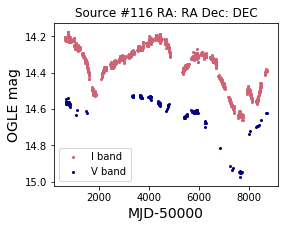

In [109]:
#could also be mistyped
try: iband, vband = o.getIV(type5[-5],cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(type5[-5],cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [105]:
for t in type3:
    try: iband, vband = o.getIV(t,cross,stack=True,plot=False,mlist=mlist1,figsize=(4,3))
    except: iband, vband = o.getIV(t,cross2,stack=True,plot=False,mlist=mlist2,figsize=(4,3))
    print(st.skew(iband['I mag']))

1.698965125436025
1.0619458938664854
1.3742649260847142
0.2042410798065222
1.2255504452425086
0.5493164721805999
0.643525913603922
1.044556365082594
1.9725517968240407
1.6470310301896853
0.8416967314208598


In [112]:
for t in type2:
    try: iband, vband = o.getIV(t,cross,stack=True,plot=False,mlist=mlist1,figsize=(4,3))
    except: iband, vband = o.getIV(t,cross2,stack=True,plot=False,mlist=mlist2,figsize=(4,3))
    print(st.skew(iband['I mag']))

1.011883388736845
0.9100859182764144
1.7880853737007774
0.7900903366950499
0.8734104213872651
2.214389490139443
1.0668974797487891
0.9403175151593929
0.6020519470798726


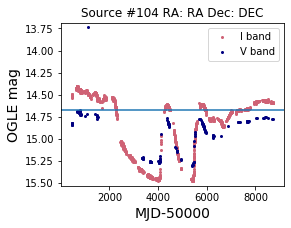

In [127]:
#lowest type 2 skew value -- makes sense
try: iband, vband = o.getIV(type2[-1],cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(type2[-1],cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))
plt.axhline(np.median(iband['I mag']),color='grey')

w/ exception of three type 5 sources, type 2 have higher skew

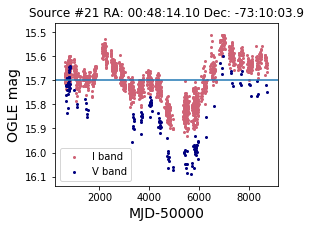

In [126]:
#skew correctly identifies that it could be type 5
try: iband, vband = o.getIV(type3[3],cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(type3[3],cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))
plt.axhline(np.median(iband['I mag']))

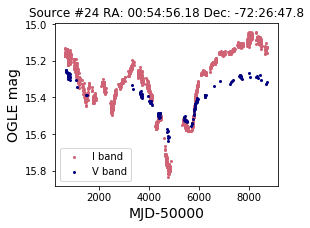

In [111]:
#could also be type5, just thought not b/c of decent symmetry
try: iband, vband = o.getIV(type3[5],cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(type3[5],cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

#### plot types in this skew-difference space

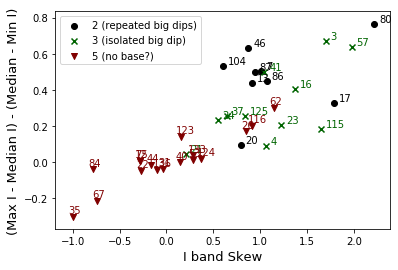

In [177]:
plt.scatter(t2skew,t2diff,color='black',label='2 (repeated big dips)')
plt.scatter(t3skew,t3diff,color='darkgreen',marker='x',label='3 (isolated big dip)')
plt.scatter(t5skew,t5diff,color='maroon',marker='v',label='5 (no base?)')
plt.xlabel('I band Skew',fontsize=13)
plt.ylabel('(Max I - Median I) - (Median - Min I)',fontsize=13)
plt.legend()
#annotate with types
for t in range(len(type2)):
    plt.text(t2skew[t]+0.05,t2diff[t]+.01,str(type2[t]))
for t in range(len(type3)):
    plt.text(t3skew[t]+0.05,t3diff[t]+.01,str(type3[t]),color='darkgreen')
for t in range(len(type5)):
    plt.text(t5skew[t]-.05,t5diff[t]+.02,str(type5[t]),color='maroon')
# plt.savefig('Figs/type235skew.png',dpi=150,bbox_inches='tight')

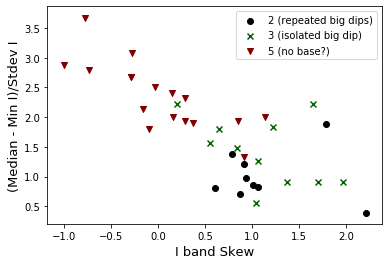

In [162]:
#for comparison: did simpler y metric of difference between median and minimum
#expect higher difference for type 5 but overall variability not accounted for
#so now it's normalized in another way: using stdev
plt.scatter(t2skew,t2mdiff,color='black',label='2 (repeated big dips)')
plt.scatter(t3skew,t3mdiff,color='darkgreen',marker='x',label='3 (isolated big dip)')
plt.scatter(t5skew,t5mdiff,color='maroon',marker='v',label='5 (no base?)')
plt.xlabel('I band Skew',fontsize=13)
plt.ylabel('(Median - Min I)/Stdev I',fontsize=13)
plt.legend()

In [188]:
#add other types as well
t1diff,t1mdiff,t1skew = typeskew(type1,printall=False)
t4diff,t4mdiff,t4skew = typeskew(type4,printall=False)
t6diff,t6mdiff,t6skew = typeskew(type6,printall=False)
t7diff,t7mdiff,t7skew = typeskew(type7,printall=False)

empty file for OIII I
empty file for OII I


In [191]:
len(type4)

5

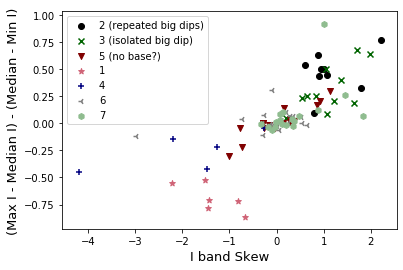

In [199]:
plt.scatter(t2skew,t2diff,color='black',label='2 (repeated big dips)')
plt.scatter(t3skew,t3diff,color='darkgreen',marker='x',label='3 (isolated big dip)')
plt.scatter(t5skew,t5diff,color='maroon',marker='v',label='5 (no base?)')
plt.scatter(t1skew,t1diff,color=pink,marker='*',label='1')
plt.scatter(t4skew,t4diff,color='navy',marker='+',label='4')
plt.scatter(t6skew,t6diff,color='grey',marker='3',label='6')
plt.scatter(t7skew,t7diff,color='darkseagreen',marker='h',label='7')

plt.xlabel('I band Skew',fontsize=13)
plt.ylabel('(Max I - Median I) - (Median - Min I)',fontsize=13)
plt.legend()
# plt.savefig('Figs/alltypes_skew.png',dpi=150,bbox_inches='tight')

Text(0, 0.5, '(Max I - Median I)/Stdev I')

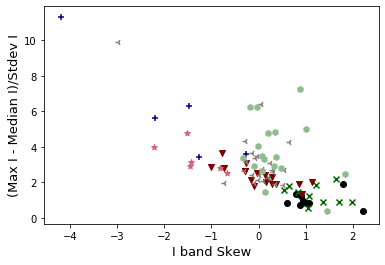

In [198]:
#version using stdev to normalize
plt.scatter(t2skew,t2mdiff,color='black',label='2 (repeated big dips)')
plt.scatter(t3skew,t3mdiff,color='darkgreen',marker='x',label='3 (isolated big dip)')
plt.scatter(t5skew,t5mdiff,color='maroon',marker='v',label='5 (no base?)')
plt.scatter(t1skew,t1mdiff,color=pink,marker='*',label='1')
plt.scatter(t4skew,t4mdiff,color='navy',marker='+',label='4')
plt.scatter(t6skew,t6mdiff,color='grey',marker='3',label='6')
plt.scatter(t7skew,t7mdiff,color='darkseagreen',marker='h',label='7')

plt.xlabel('I band Skew',fontsize=13)
plt.ylabel('(Max I - Median I)/Stdev I',fontsize=13)
# plt.legend(loc='upper center')
# plt.ylim(0,14)


#### get change in max (change in faintest) and then change in min
- compare stdev to stdev/overall stdev (relative rather than absolute variability)

0.33099208449749945

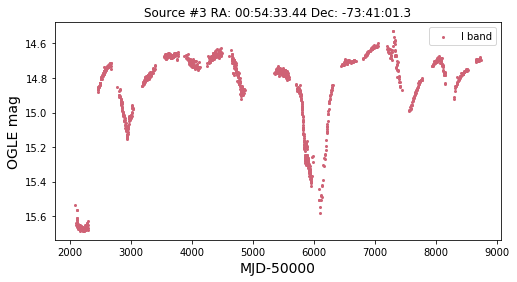

In [7]:
cut(3,cut=5,retstd=True,retrange=False,calib=False,plot=True,text=False,statistic='max',glob=False,retsplit=False,window=200)

In [54]:
maxstd = []
maxstdr = [] #relative: divided by overall std
for s in srcns:
    try: m = cut(s,cut=5,retstd=True,retrange=False,calib=False,plot=False,text=False,statistic='max',glob=True,retsplit=False,window=200)
    except: m = np.nan
    maxstd.append(m)
    maxstdr.append(m/np.std(iband['I mag']))

empty file for OIII I
empty file for OII I
empty file for OIII I


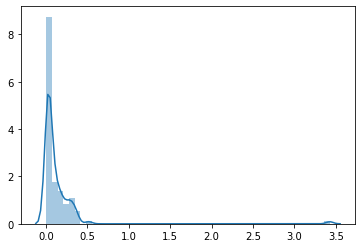

In [57]:
sb.distplot(maxstd)

In [61]:
alls['max std 5'] = maxstd
# alls['rel max std 5'] = maxstdr

In [66]:
minstd = []
minstdr = [] #relative: divided by overall std
for s in srcns:
    try: m = cut(s,cut=5,retstd=True,retrange=False,calib=False,plot=False,text=False,statistic='min',glob=True,retsplit=False,window=200)
    except: m = np.nan
    minstd.append(m)
    minstdr.append(m/np.std(iband['I mag']))

empty file for OIII I
empty file for OII I
empty file for OIII I


In [67]:
alls['min std 5'] = minstd

In [64]:
#base at faintest should have relatively low stdev of max
twocol(ifc='base string',thenc='max std 5',value='base at faintest')

0.06056599706105739
0.04245750816993423
0.006675327707311864
0.04290640977756108
0.046687899931352264
0.02516823394678292
0.016906803364325776
0.043471369888698576
0.046046063892584504
0.022948638303829955
0.03334666400106672
0.007939773296511856
0.32537031210606804
0.12550123505368424
0.010707007051458833
0.01899894733926138


In [68]:
twocol(ifc='base string',thenc='min std 5',value='base at faintest')

0.11889390228266591
0.0683444218645533
0.14571533893176827
0.2746018208242617
0.015160474926597734
0.05820171818769626
0.09986270575144601
0.26194732294871803
0.10649957746395063
0.1903869743443598
0.1495521313789945
0.04777698190551595
0.10694222739404706
0.3016173735049094
0.053471487729443365
0.29771019465245113


In [69]:
#expect low
twocol(ifc='base string',thenc='min std 5',value='base at brightest')

0.06487341520222242
0.006387487769068934
0.009350935782048653
0.020145470955031566
0.1011916992643172
0.06844968955371519
0.01691153452528774
0.03828837943815337
0.03421344764854844
0.04494707999414427
0.013661625086350588
0.025943014474035454
0.2826227167090429
0.024434401977539193
0.02815244216759919
0.016407315441595037
0.020558210038814015


In [65]:
twocol(ifc='base string',thenc='max std 5',value='base at brightest')

0.33099208449749945
0.053767648265476635
0.1655434686117213
0.17618217844038597
0.28105558169159345
0.12738225936134143
0.12831679547120878
0.2505550638083373
0.27951343438196297
0.2933425301588576
0.026858145877927345
0.014824304368165094
0.5187745560453021
0.025560907652116143
0.29651104532546463
0.04097316194779244
0.0875159414049805


In [9]:
#test setting boundary at 0.1 to see type as a result
#starting with max -- so has to do with base at faintest
for a in range(len(alls)):
    if alls.loc[a]['max std 5']<0.1:
        atype = alls.loc[a]['type']
        #ignoring types 6 and 7
        if atype != '6' and atype != '7': print(atype)

3
4
4
4
1+?
1+2
5
1
1+5
2
3
5
5
1+5
5
5
5
1
1
4
4
5
2+5
5
5
3
5
1
1
5
5
nan


low stdev of maxima (faintest) gives type 1 (good); type 3 (fine?), 4 (fine?), 5 (good), and 6 (fine, since "potential faint base"
- i.e. the dippers can have low stdev max

In [10]:
#test setting boundary at 0.1 to see type as a result
#now min: brightest
for a in range(len(alls)):
    if alls.loc[a]['min std 5']<0.1:
        atype = alls.loc[a]['type']
        #ignoring types 6 and 7
        if atype != '6' and atype != '8': print(atype)

3+5
3
3
4
2
7
1+?
1+2
5
3
2
3
5
3
3
5
1+2
1+5
3+5
3
2+6
5
3
7
5
2
1
3
7
5
7
7
7
7
2+5
5
7
2
7
5
2
2
7
7
7
2
7
nan
7
3
5
5
5
3
1
5
5
7
7


- get all types based on low stdev of min
- to review: can maybe save these values but not clearly helping differentiation

# dips
- get big dip sources separated, then separate out two types (3, 4)

In [202]:
#again, from ChangingFeatures
def outlier(srcn,ncut=5,npoints=False,time=False,calib=False,plot=True,text=False,statistic='max',glob=False,retsplit=False,window=200,printall=True,sig=1):
    '''use cut function to get stats, and then differentiate between outliers and repeated changes
    also check for monotonic changes
    sig: stdev from mean to be considered outlier'''
    #get list of stats for srcn
    stats = cut(srcn,cut=ncut,npoints=npoints,time=time,retstd=False,retrange=False,calib=calib,plot=plot,text=plot,statistic=statistic,glob=glob,retsplit=retsplit,window=window)
    if printall:
        #to do: look for only n (3?4?) monontonic changes
        if o.strictly_increasing(stats): print(f'{statistic} is strictly increasing')
        elif o.strictly_decreasing(stats): print(f'{statistic} is strictly decreasing')
    #look for outliers in stats (in this case: one sigma from mean)
    stats = np.array(stats)
    upfilt = stats>np.mean(stats)+sig*np.std(stats)
    lowfilt = stats<np.mean(stats)-sig*np.std(stats)
    upouts = stats[upfilt]
    lowouts = stats[lowfilt]
    #get # of chunk with those outliers
    uploc = list(np.where(upfilt)[0]+1) #add one for indexing to start at 1 (first chunk)
    lowloc = list(np.where(lowfilt)[0]+1)
    if printall: 
        print(f'{len(upouts)} values of **{statistic}** {sig} sigma from mean using {ncut} LC chunks')
        print(f'above outliers at chunks {uploc} out of {ncut}')

        print(f'{len(lowouts)} upper outliers of {statistic} {sig} sigma from mean using {ncut} LC chunks')
        print(f'above outliers at chunks {lowloc} out of {ncut}')
    return stats

In [12]:
type3 = []
for a in range(len(alls)):
    if alls.loc[a]['type']=='3':
        print(alls.loc[a]['src_n'])
        type3.append(alls.loc[a]['src_n'])

3
4
16
21
23
24
37
41
57
115
125


In [14]:
#updated: type 2 and 4 now both in type2
type2 = []
for a in range(len(alls)):
    if alls.loc[a]['type']=='2':
#         print(alls.loc[a]['src_n'])
        type2.append(alls.loc[a]['src_n'])

In [15]:
len(type2)

9

2 values of **max** 1 sigma from mean using 5 LC chunks
above outliers at chunks [1, 4] out of 5
0 upper outliers of max 1 sigma from mean using 5 LC chunks
above outliers at chunks [] out of 5
2 values of **max** 1 sigma from mean using 5 LC chunks
above outliers at chunks [2, 3] out of 5
1 upper outliers of max 1 sigma from mean using 5 LC chunks
above outliers at chunks [4] out of 5
1 values of **max** 1 sigma from mean using 5 LC chunks
above outliers at chunks [4] out of 5
0 upper outliers of max 1 sigma from mean using 5 LC chunks
above outliers at chunks [] out of 5
1 values of **max** 1 sigma from mean using 5 LC chunks
above outliers at chunks [4] out of 5
0 upper outliers of max 1 sigma from mean using 5 LC chunks
above outliers at chunks [] out of 5
1 values of **max** 1 sigma from mean using 5 LC chunks
above outliers at chunks [2] out of 5
0 upper outliers of max 1 sigma from mean using 5 LC chunks
above outliers at chunks [] out of 5


array([14.85 , 15.038, 14.74 , 14.719, 14.69 ])

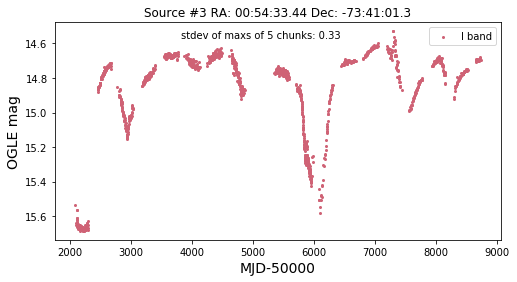

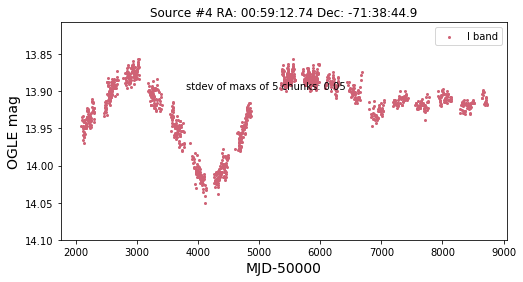

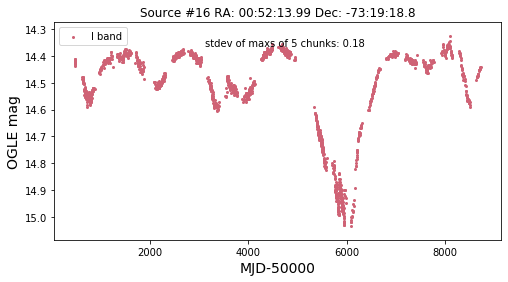

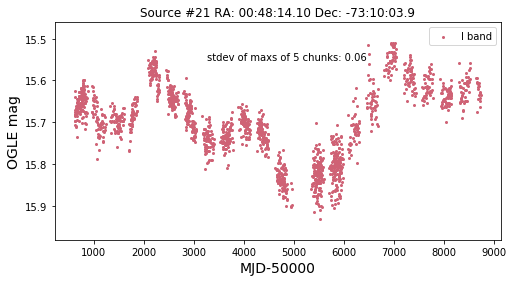

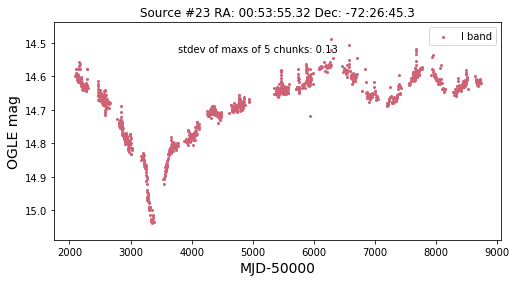

In [95]:
outlier(3) #correctly identifies that there are two dips, and that they're not in neighboring chunks
outlier(4) #tested, and can't do more than one sigma
outlier(16)
outlier(21)
outlier(23)

1 values of **max** 1 sigma from mean using 5 LC chunks
above outliers at chunks [3] out of 5
1 upper outliers of max 1 sigma from mean using 5 LC chunks
above outliers at chunks [5] out of 5
max is strictly decreasing
1 values of **max** 1 sigma from mean using 5 LC chunks
above outliers at chunks [1] out of 5
1 upper outliers of max 1 sigma from mean using 5 LC chunks
above outliers at chunks [5] out of 5
1 values of **max** 1 sigma from mean using 5 LC chunks
above outliers at chunks [4] out of 5
1 upper outliers of max 1 sigma from mean using 5 LC chunks
above outliers at chunks [5] out of 5
1 values of **max** 1 sigma from mean using 5 LC chunks
above outliers at chunks [2] out of 5
1 upper outliers of max 1 sigma from mean using 5 LC chunks
above outliers at chunks [3] out of 5
1 values of **max** 1 sigma from mean using 5 LC chunks
above outliers at chunks [1] out of 5
0 upper outliers of max 1 sigma from mean using 5 LC chunks
above outliers at chunks [] out of 5
2 values of **

array([14.239, 14.226, 13.931, 14.437, 14.44 ])

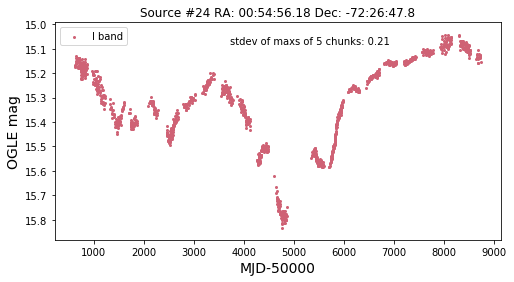

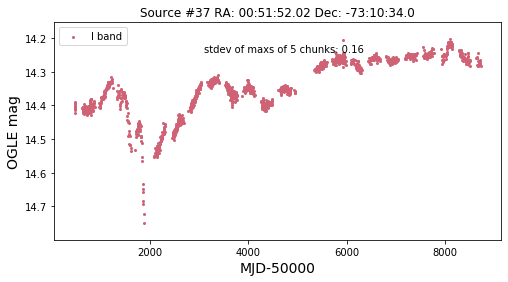

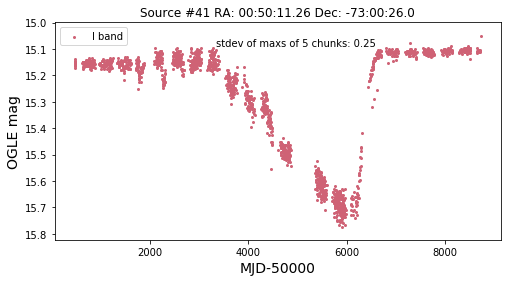

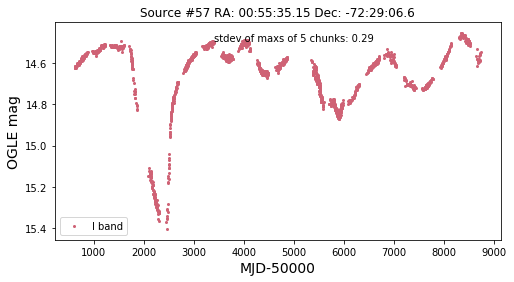

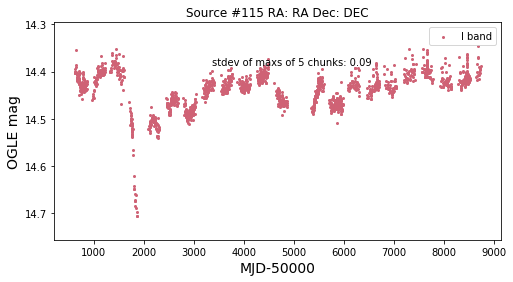

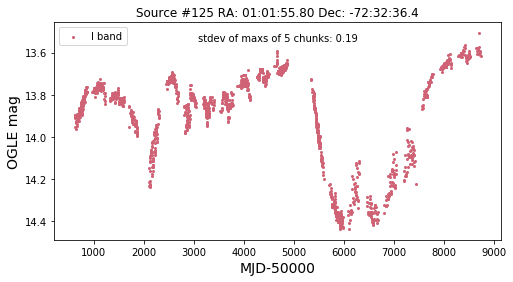

In [94]:
outlier(24)
outlier(37)
outlier(41)
outlier(57)
outlier(115)
outlier(125,sig=0.9) #fails here if 1sigma

2 values of **max** 1 sigma from mean using 10 LC chunks
above outliers at chunks [1, 8] out of 10
1 upper outliers of max 1 sigma from mean using 10 LC chunks
above outliers at chunks [4] out of 10
2 values of **max** 1 sigma from mean using 10 LC chunks
above outliers at chunks [4, 5] out of 10
1 upper outliers of max 1 sigma from mean using 10 LC chunks
above outliers at chunks [7] out of 10
2 values of **max** 1 sigma from mean using 10 LC chunks
above outliers at chunks [7, 8] out of 10
0 upper outliers of max 1 sigma from mean using 10 LC chunks
above outliers at chunks [] out of 10
2 values of **max** 1 sigma from mean using 10 LC chunks
above outliers at chunks [7, 8] out of 10
2 upper outliers of max 1 sigma from mean using 10 LC chunks
above outliers at chunks [3, 10] out of 10
1 values of **max** 1 sigma from mean using 10 LC chunks
above outliers at chunks [3] out of 10
0 upper outliers of max 1 sigma from mean using 10 LC chunks
above outliers at chunks [] out of 10
2 valu

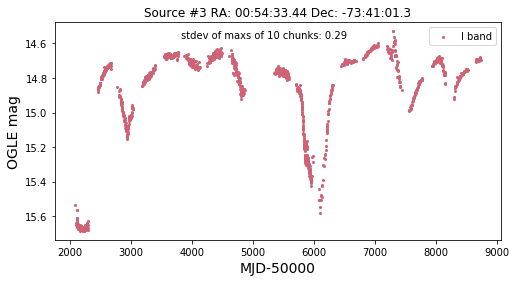

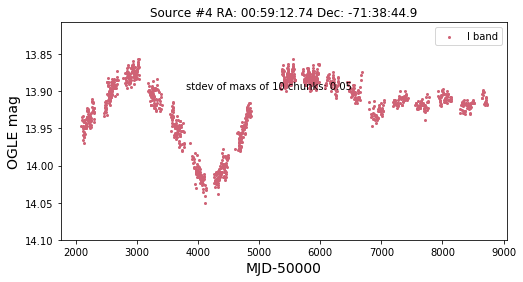

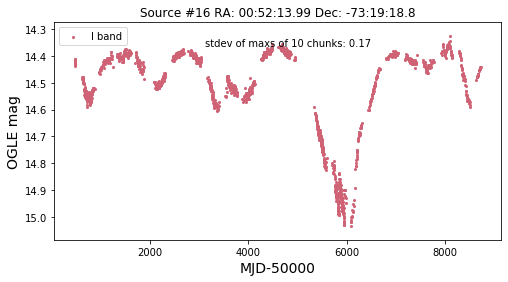

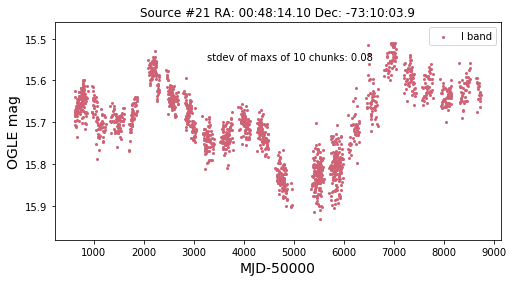

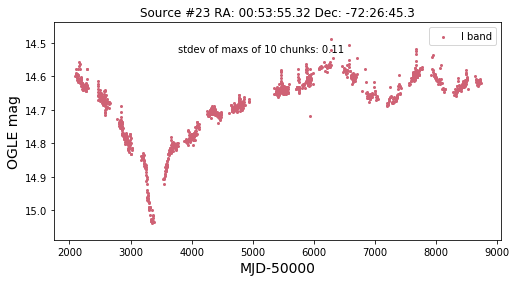

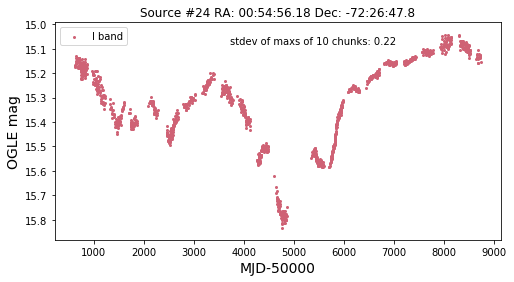

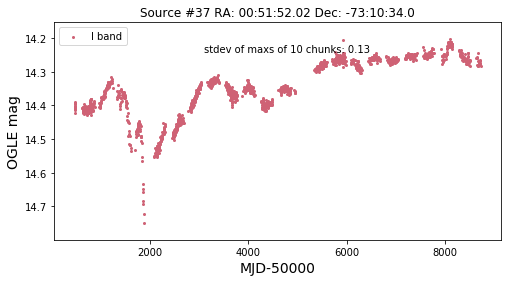

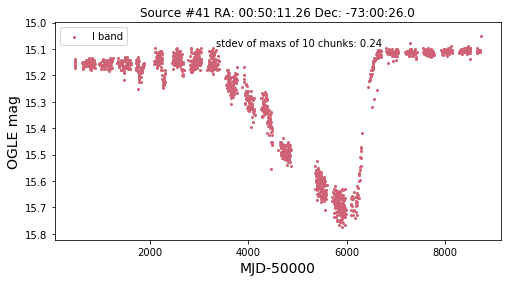

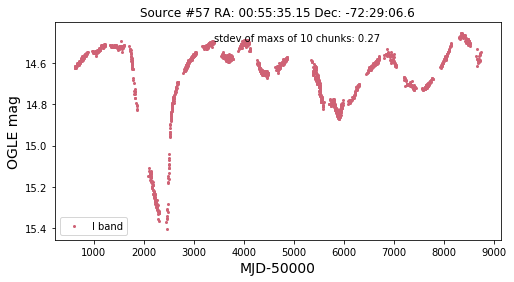

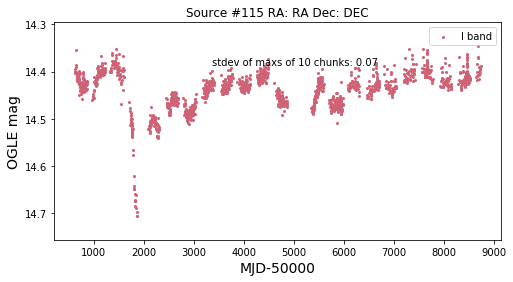

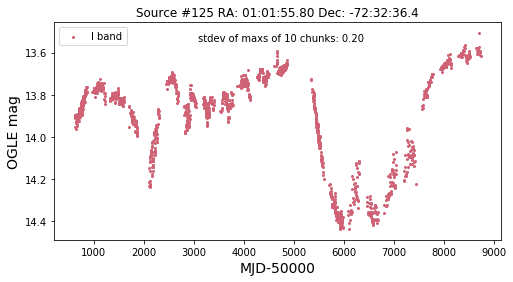

In [342]:
for a in type3:
    outlier(a,ncut=10)

test with more cuts didn't really get a better result

2 values of **max** 1 sigma from mean using 10 LC chunks
above outliers at chunks [1, 2] out of 10
2 upper outliers of max 1 sigma from mean using 10 LC chunks
above outliers at chunks [7, 8] out of 10
2 values of **max** 1 sigma from mean using 10 LC chunks
above outliers at chunks [8, 10] out of 10
2 upper outliers of max 1 sigma from mean using 10 LC chunks
above outliers at chunks [1, 2] out of 10
2 values of **max** 1 sigma from mean using 10 LC chunks
above outliers at chunks [9, 10] out of 10
3 upper outliers of max 1 sigma from mean using 10 LC chunks
above outliers at chunks [2, 3, 6] out of 10
2 values of **max** 1 sigma from mean using 10 LC chunks
above outliers at chunks [1, 10] out of 10
0 upper outliers of max 1 sigma from mean using 10 LC chunks
above outliers at chunks [] out of 10
2 values of **max** 1 sigma from mean using 10 LC chunks
above outliers at chunks [9, 10] out of 10
0 upper outliers of max 1 sigma from mean using 10 LC chunks
above outliers at chunks [] o

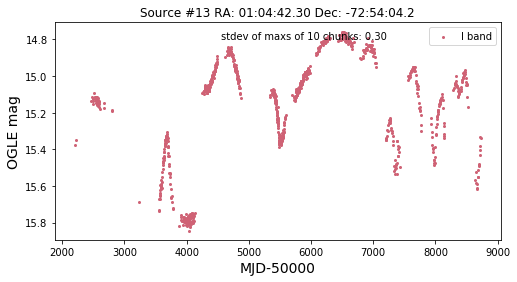

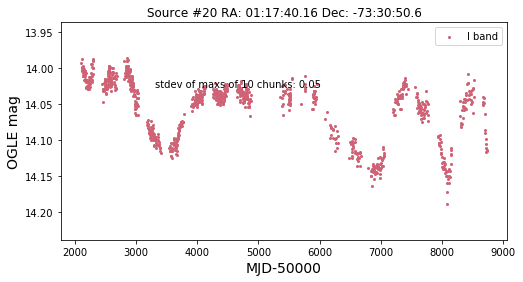

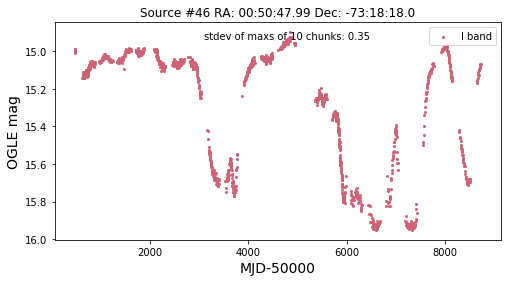

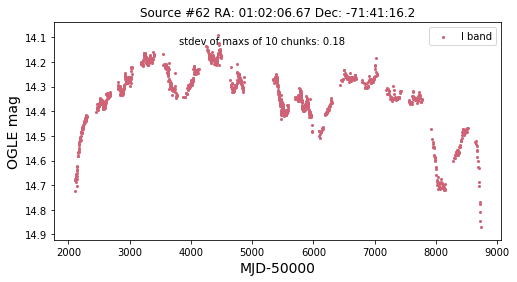

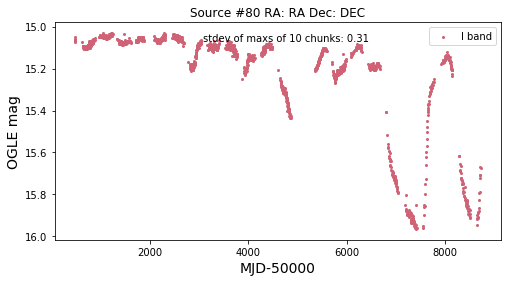

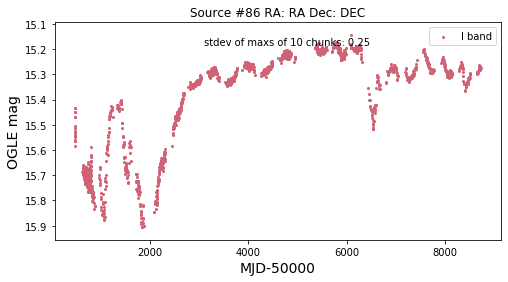

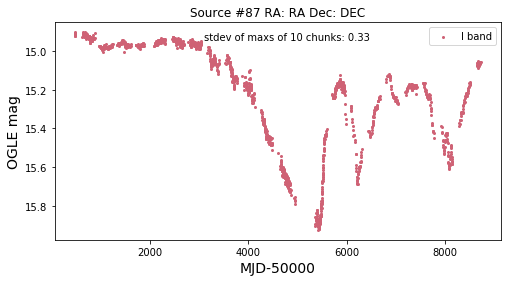

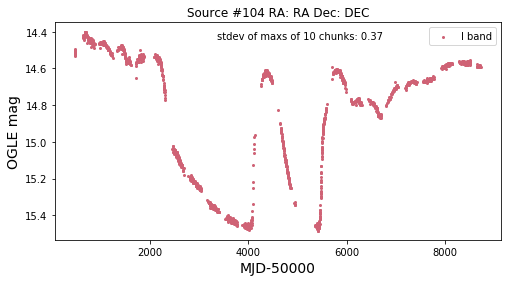

In [97]:
for a in range(len(alls)):
    if alls.loc[a]['type']=='2':
        s = alls.loc[a]['src_n']
        outlier(s,ncut=10)

works and gives multiple values for type 4 iff ncut is 10
- with only 5, hard to be far from mean since there are multiple dips

### idea: try cut again with many more chunks and look for monotonic changes to max as evidence of dips
- it's basically a method of smoothing
- statistic itself basically doesn't matter

In [201]:
def mono(smooth,minimum=4,one=False):
    num_mon = 0 #counter for monotonic
    i = 0 #begin with first point
    #number of immediate switches from monotonically increasing to monotonically decreasing
    #decide whether to also test the opposite
    nswitch = 0
    this_inc = False
    slocs = []
    onelocs = []
    #repeat for points after peak
    while i+3 < len(smooth): 
        sub = 2
        mono = True
        while mono and i+sub<len(smooth):
            #saves whether or not previous monotonic trend was increasing
            mono,inc = o.monotonic(smooth[i:i+sub],retwhich=True)
            #be careful since I band flipped
            if mono: this_inc = inc #final inc that's saved is during monotonicity
            sub+=1
        #add to num_mon based on what sub left off on; it automatically gets to 3
        if sub-1>minimum: #minimum 3 passes as long as sub is 4
            #subtracts 3 b/c sub automatically gets there
            num_mon += sub-3 #adds nothing if there aren't monotonic points of at least minimum
            #add to nswitch if this round was not increasing, last round was increasing, and last round is usable (min points) 
            if this_inc: #if it was increasing right before the start
                #look ahead to determine if it switches to monotonic decreasing
                #trying to only require 2
                mon,tinc = o.monotonic(smooth[i+sub-2:i+sub+(minimum-3)],retwhich=True)
                #put not tinc back in?
                if mon and not tinc: #if next three monotonically decreasing, add 1 to number of switches
                    nswitch+=1
                    slocs.append(i+sub-3)
            #other way of counting: minimum inc (fainter)
            if one and this_inc:
                onelocs.append(i+sub-3)
            elif one and not this_inc and i>3: #decreasing
                onelocs.append(i-1)
        #now reset i to i+sub to start again
        i += sub-2 #adds 1 if no monotonic behavior
    if one: return onelocs,num_mon
    else: return slocs,num_mon

consider putting error bars on "monotonic" by allowing slight (define?) deviations from monotonic to still be counted

In [200]:
def bigdip(s,ncut=30,npoints=False,time=False,minimum=4,statistic='median',plot=True,one=False,peaks=False,
           spline=False,sig=0,printall=False,printtype=True,frommin=False,checkbase=True):
    '''
    spline (bool): use spline trend rather than cuts when searching for dips
    '''
    if spline:
        try: iband, vband = o.getIV(t,cross,stack=True,plot=plot,mlist=mlist1,figsize=(4,3))
        except: iband, vband = o.getIV(t,cross2,stack=True,plot=plot,mlist=mlist2,figsize=(4,3))
        #set smooth variable to spline trend
        flatten, smooth = o.splinedetrend(iband,retspline=True)
    else:
        smooth = cut(s,cut=ncut,npoints=npoints,time=time,retstd=False,retrange=False,calib=False,plot=False,text=False,statistic=statistic,glob=False,retsplit=False,window=200)
    #first check that faint (max) is more variable than bright (min)
    if checkbase:
        mincut = cut(s,cut=10,npoints=npoints,time=time,retstd=False,retrange=False,calib=False,plot=False,text=False,statistic='min',glob=False,retsplit=False,window=200)
        minstd = np.std(mincut)
        maxcut = cut(s,cut=10,npoints=npoints,time=time,retstd=False,retrange=False,calib=False,plot=False,text=False,statistic='max',glob=False,retsplit=False,window=200)
        maxstd = np.std(maxcut)
        if minstd > maxstd: #bright more variable
            t3 = False
            t2 = False
            if printtype: print('neither type 3 or type 2')
            return t3,t2      
        #but also enforce if both are variable (above is just if bright *more* variable than faint)
#         elif 
#             t3 = False
#             t2 = False
#             if printtype: print('neither type 3 or type 2')
#             return t3,t2
    if plot:
        plt.figure(figsize=(4,3))
        plt.plot(np.arange(len(smooth)),smooth,color='black')
        maxi,mini = np.max(smooth),np.min(smooth)
        plt.ylim(maxi+.02,mini-.02)
    if peaks:
        pks = signal.find_peaks(smooth,height=0.2)
        slocs = pks[0]
        #also check in boundaries are dips (first and last point): condition is just being lower than neighbor
        if smooth[0]>smooth[1]:
            slocs = list(slocs)
            slocs.insert(0,0) #put 0 at beginning of location list
        #check end point
        if smooth[-1]>smooth[-2]:
            slocs = list(slocs)
            slocs.append(len(smooth)-1)
        slocs = np.array(slocs)
        if printall: print(slocs)
    else: slocs,num_mon = mono(smooth,minimum=minimum,one=one)
    #plot points of dips
    smooth = np.array(smooth) #allows for indexing in plot
    if plot: 
        plt.scatter(slocs,smooth[slocs],color='red')
    #sig higher than 0 indicates dips should be checked for outliers
    if sig>0:
        dips = smooth[slocs] #could probably do this check without peaks, but those can be useful anyway
        #upfilt corresponds to points fainter than sig sigma from median
        if frommin: start = np.min(smooth)
        else: start = np.median(smooth)
        upfilt = dips>start+sig*np.std(smooth)
        if plot: plt.axhline(start+sig*np.std(smooth),color='navy',label='dip cutoff',alpha=0.3)
        upout = dips[upfilt]
        uploc = list(np.where(upfilt)[0]) #+1 after [0] if indexing from 1 preferred
        #locations of sig sigma dips within all of smooth
        siglocs = slocs[upfilt]
        if printall: print(f'{len(upout)} dips {sig} sigma from median; locations {uploc}')
        if len(upout)>0: 
            t3 = True #possible Type 3; then will add in type4 bool below
            t2 = False #initialize Type 4 bool
        else:
            t3 = False
            t2 = False
        blist = [] #list of number of ~base values between dips
        #now, if there are > 1 dip, verify that smooth returned near bright base in between
        if len(upout)>1:
            #for each pair of dips
            for u in range(1,len(siglocs)):
                #smooth values between dips
                btwn = smooth[siglocs[u-1]:siglocs[u]]
                #filter to values that are close to overall min (bright)
#                 bright = btwn[btwn<np.median(smooth)+np.std(smooth)/4]
                #instead, just requires it goes above dip cutoff
                bright = btwn[btwn<start+sig*np.std(smooth)]
                if len(bright)>0: 
                    if printall: print(f'returns to bright base with {len(bright)} (of {ncut} total) ~base points between dips')
                    #also check that they're neighboring dips (can change condition to allow for 1 between?)
                    if uploc[u] - uploc[u-1] == 1: 
                        t3 = False
                        t2 = True
                else: 
                    if printall: print('does not return to base between dips so likely part of same dip, but checking for comparable depth')
                    #still can be real if the two dips are comparably faint
                    if np.abs(smooth[siglocs[u-1]]-smooth[siglocs[u]])<0.1:
                        if printall: print('still believable since close in mag (<0.1 mag diff)')
                        #also check that they're neighboring dips (can change condition to allow for 1 between?)
                        if uploc[u] - uploc[u-1] == 1: 
                            t3 = False
                            t2 = True
                blist.append(len(bright))
            #if plot: plt.axhline(np.median(smooth)+np.std(smooth)/4,color='darkseagreen',alpha=0.2,label='return cutoff')  
            if printall: print(blist)
        if plot: plt.legend()
        if printtype: 
            if t3: print('Type 3')
            elif t2: print('Type 2')
            else: print('neither type 3 or type 2')
            
    if sig>0:return t3,t2
    #return len(slocs)

options
- instead of return cutoff (which is combined with requirement of difference <0.1 mag, can just require it goes above dip cutoff

- next: how close in faintness are the neighboring dips
    - only count if of comparable dipping
- replace print statements with bools
    - to be real neighbors: should be neighboring dips in indexing and there should be a return to base in between
    
    
- sometimes, even if there's a return to ~base between dips (e.g. 86), it's not picked up in smoothed version
- so perhaps the other option is to check that the neighboring dips are of comparable depth
    - b/c the other mistake should result from a slight dip on the way up

Type 3


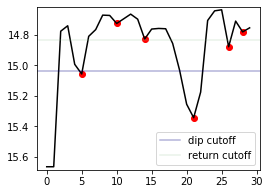

In [18]:
locs,smooth = bigdip(type3[0],peaks=True,sig=1)

Type 3


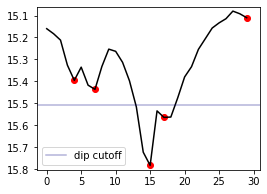

In [31]:
locs,smooth = bigdip(type3[5],peaks=True,sig=1)

Type 2


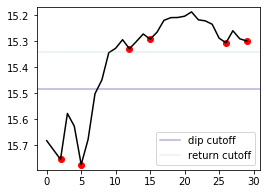

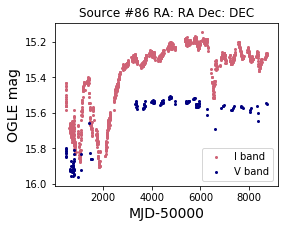

In [19]:
ind = 6
locs,smooth = bigdip(type2[ind],peaks=True,sig=1)
try: iband, vband = o.getIV(type2[ind],cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
except: iband, vband = o.getIV(type2[ind],cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

in example above, two values are a stdev from the median
- only the big dip is 2stdev from the median
- example condition: they're not neighbors, but then gets complicated when one dip identified as 2 or 3

#### problem to address: since chunks are not evenly divided in time (instead, in points?) this representation isn't accurately spaced

ambiguity with 24 and 21

In [27]:
# for t in type3:
#     bigdip(t,peaks=True,spline=True)
#     try: iband, vband = o.getIV(t,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
#     except: iband, vband = o.getIV(t,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

Type 3
Type 3
Type 3
Type 3
Type 3
Type 3
Type 3
Type 3
Type 3
Type 3
Type 3


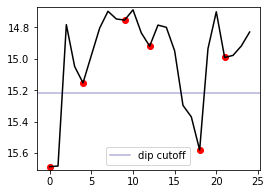

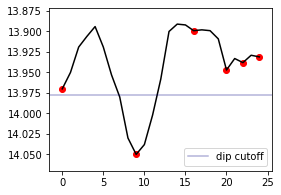

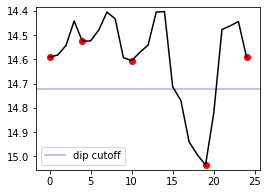

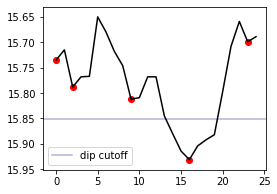

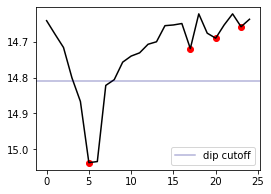

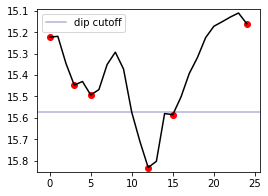

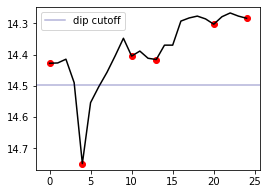

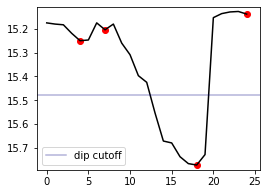

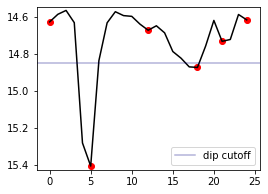

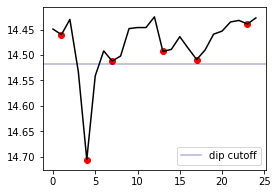

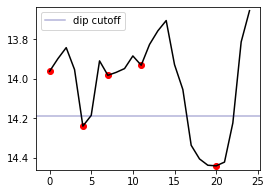

In [203]:
#using scipy find_peaks
for t in type3:
    bigdip(t,ncut=25,statistic='max',peaks=True,sig=1)
    #plot original LC for comparison
#     try: iband, vband = o.getIV(t,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
#     except: iband, vband = o.getIV(t,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

based on the above, would then need to:
- filter out bright peak values
    - filter is based on original data
- then somehow decide what only counts as one dip
    - some sort of separation in both axes
    - no monotonic change of depth
    
for type 4
- check each boundary: is it low?

for some type 4: can probably be identified with not having faint base; decent variability; 

Type 2
Type 2
Type 2
Type 2
Type 2
Type 2
Type 2
Type 2
Type 2


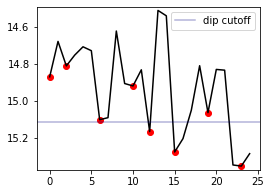

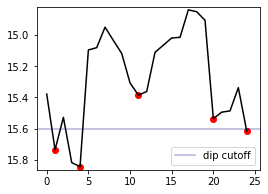

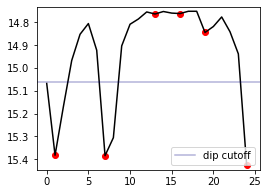

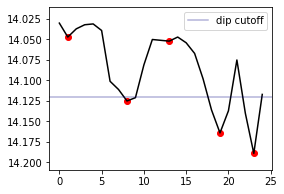

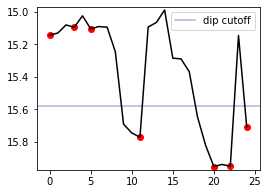

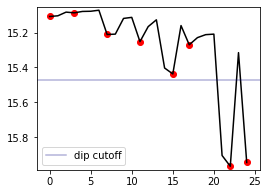

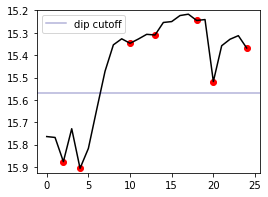

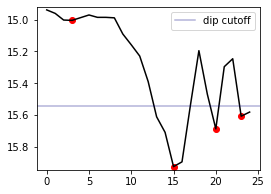

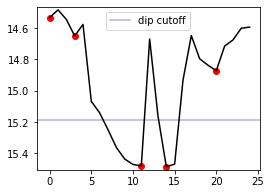

In [204]:
#scipy signal peak-finding
for t in type2:
    bigdip(t,ncut=25,statistic='max',peaks=True,sig=1)
#     try: iband, vband = o.getIV(t,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
#     except: iband, vband = o.getIV(t,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

In [74]:
# #using mono function
# for t in type3:
#     bigdip(t,ncut=30,statistic='max',minimum=3,one=True)

In [75]:
# for t in type4:
#     bigdip(t,ncut=30,statistic='max',minimum=3,one=True)
#     #to get sense of what original LC looks like
#     try: iband, vband = o.getIV(t,cross,stack=True,plot=True,mlist=mlist1,figsize=(4,3))
#     except: iband, vband = o.getIV(t,cross2,stack=True,plot=True,mlist=mlist2,figsize=(4,3))

# make sure no false positives

In [22]:
type1 = []
for a in range(len(alls)):
    if alls.loc[a]['type']=='1':
        type1.append(alls.loc[a]['src_n'])

In [205]:
for t in type1:
    bigdip(t,ncut=25,statistic='max',sig=1,peaks=True,plot=False)

neither type 3 or type 2
neither type 3 or type 2
neither type 3 or type 2
neither type 3 or type 2
neither type 3 or type 2
neither type 3 or type 2


In [26]:
type4 = [] #greatest variability in sharp peaks
for a in range(len(alls)):
    if alls.loc[a]['type']=='4':
        type4.append(alls.loc[a]['src_n'])

In [206]:
#want type 2 to be type 4s anyway
for t in type4:
    bigdip(t,ncut=25,statistic='max',sig=1,peaks=True,plot=True)

neither type 3 or type 2
neither type 3 or type 2
neither type 3 or type 2
neither type 3 or type 2
neither type 3 or type 2


In [207]:
type5 = [] #greatest variability in sharp peaks
for a in range(len(alls)):
    if alls.loc[a]['type']=='5':
        type5.append(alls.loc[a]['src_n'])
for t in type5:
    bigdip(t,ncut=25,statistic='max',sig=1,peaks=True,plot=False)

Type 3
neither type 3 or type 2
Type 3
neither type 3 or type 2
neither type 3 or type 2
neither type 3 or type 2
neither type 3 or type 2
Type 2
Type 3
neither type 3 or type 2
Type 3
neither type 3 or type 2
Type 3
Type 3
Type 2
Type 3
Type 3


In [35]:
#DUPLICATES
# for t in [12,75]:
#     try: iband, vband = o.getIV(t,cross,stack=True,plot=True,mlist=mlist1,figsize=(8,5))
#     except: iband, vband = o.getIV(t,cross2,stack=True,plot=True,mlist=mlist2,figsize=(8,5))

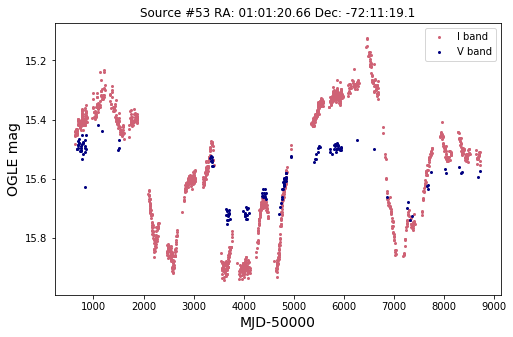

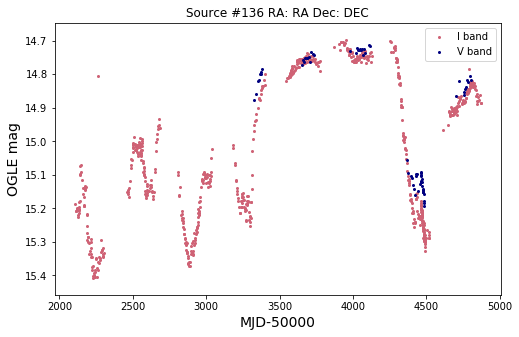

In [34]:
#interestingly similar but not duplicates
for t in [53,136]:
    try: iband, vband = o.getIV(t,cross,stack=True,plot=True,mlist=mlist1,figsize=(8,5))
    except: iband, vband = o.getIV(t,cross2,stack=True,plot=True,mlist=mlist2,figsize=(8,5))

(16.85, 16.55)

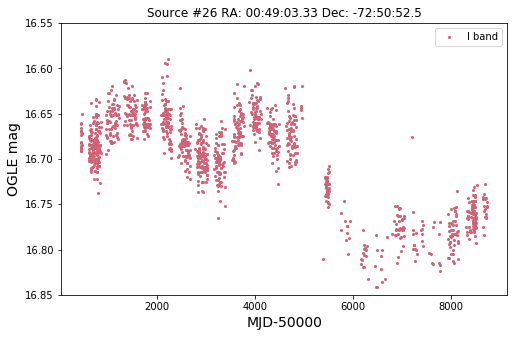

In [43]:
iband = o.getIV(26,cross,stack=True,plot=True,mlist=mlist1,figsize=(8,5),both=False)
plt.ylim(16.85,16.55)

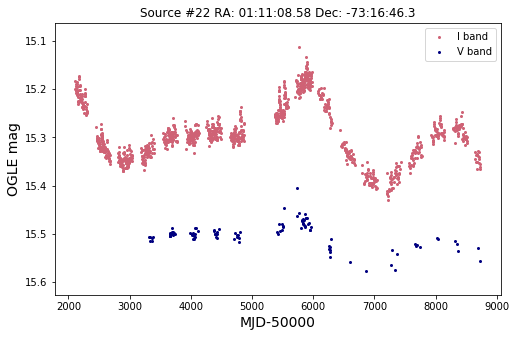

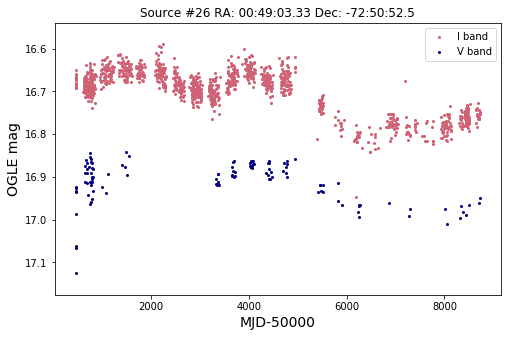

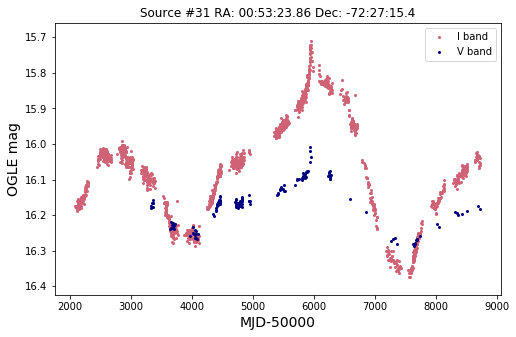

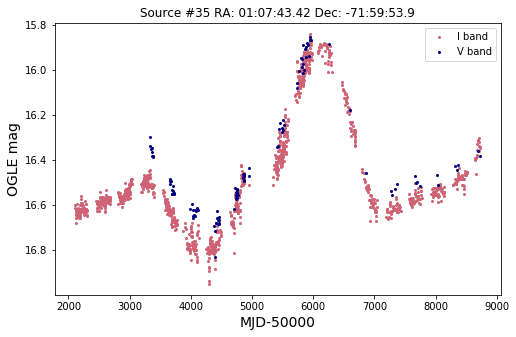

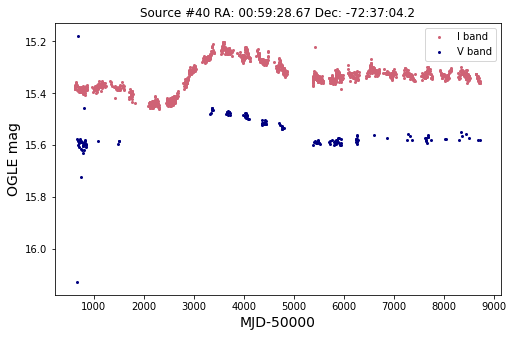

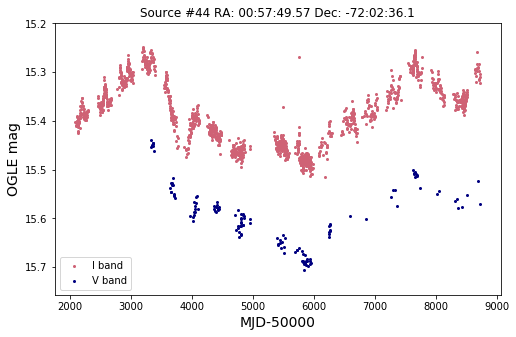

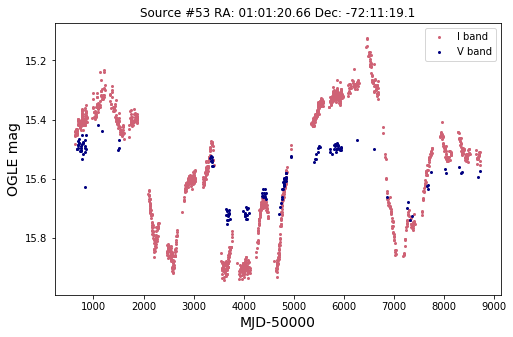

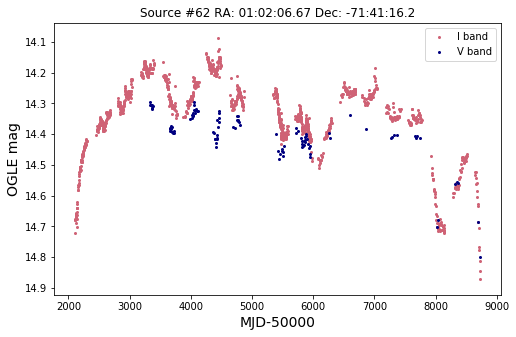

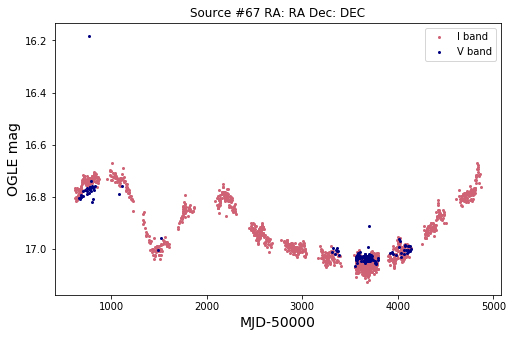

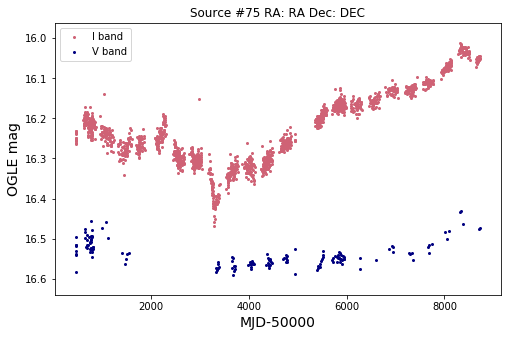

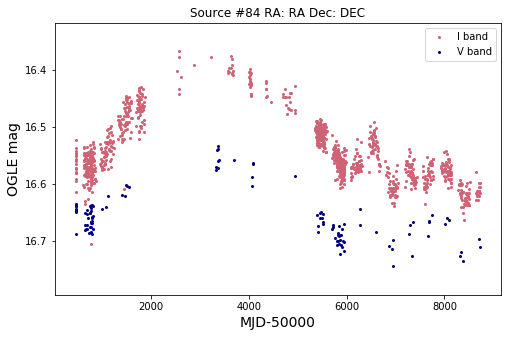

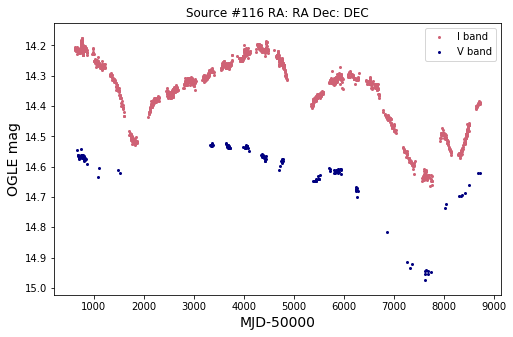

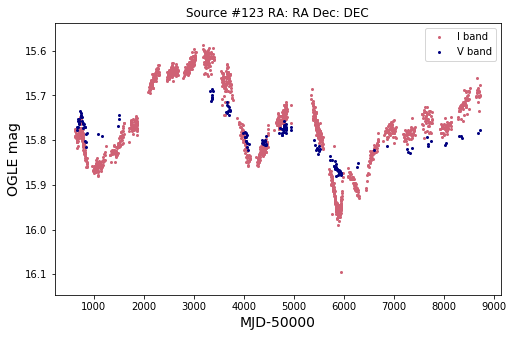

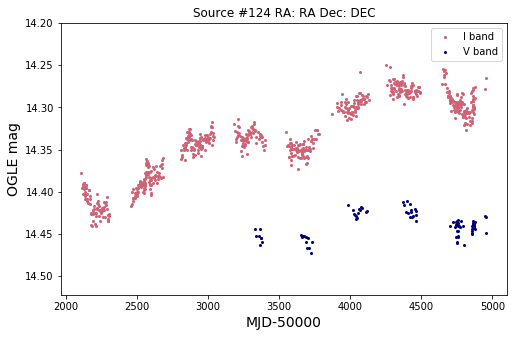

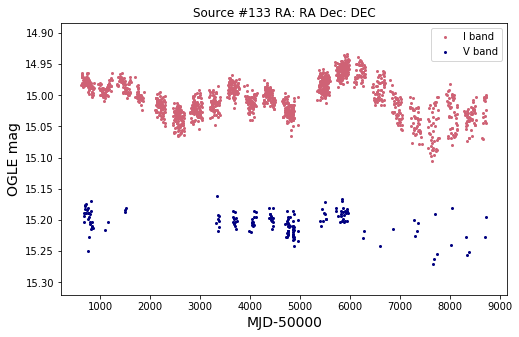

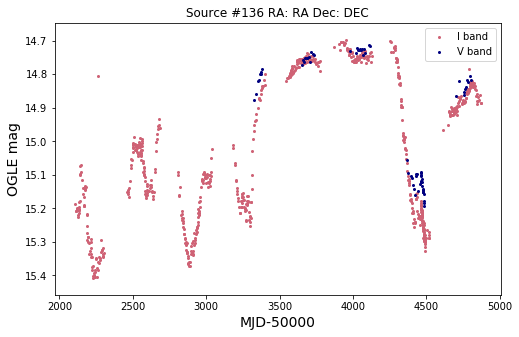

In [31]:
for t in type5[1:]:
    try: iband, vband = o.getIV(t,cross,stack=True,plot=True,mlist=mlist1,figsize=(8,5))
    except: iband, vband = o.getIV(t,cross2,stack=True,plot=True,mlist=mlist2,figsize=(8,5))

In [76]:
# for t in type4:
#     try: iband, vband = o.getIV(t,cross,stack=True,plot=True,mlist=mlist1,figsize=(8,5))
#     except: iband, vband = o.getIV(t,cross2,stack=True,plot=True,mlist=mlist2,figsize=(8,5))

#### extend to see if the peak-finding with this method is helpful
- one important way to differentiate above is to require some difference between the dip maximum and the overall min, stdev, skew, etc.

In [369]:
twocol(ifc='type',thenc='I skew',value='3')

1.69896512543603
1.06194589386649
1.37426492608471
0.204241079806522
1.22555044524251
0.5493164721806
0.643525913603922
1.04455636508259
1.97255179682404
1.64703103018968
0.84169673142086


1 values of **max** 1 sigma from mean using 5 LC chunks
above outliers at chunks [4] out of 5
0 upper outliers of max 1 sigma from mean using 5 LC chunks
above outliers at chunks [] out of 5


array([15.788, 15.812, 15.88 , 15.931, 15.797])

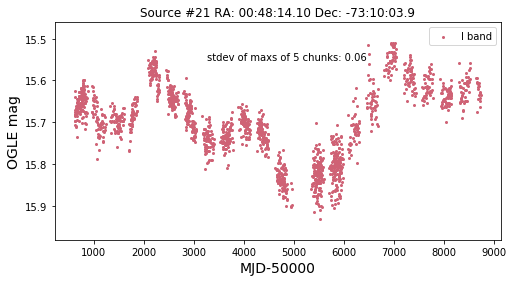

In [366]:
# outlier(type3[3]) #lowest skew

In [370]:
twocol(ifc='type',thenc='I skew',value='1')

-0.815679276209365
-1.51915337678549
-2.20614242053058
-1.44675221925231
-0.674991325302326
-1.43437250415903


I skew also helps identify base, as shown above

In [373]:
# for t in ['1','2','3','4','5','6','7','8']:
#     twocol(ifc='type',thenc='I skew',value=t)
#     print('\n')

In [380]:
twocol(ifc='type',thenc='I range',value='3')

1.159
0.193000000000001
0.710000000000001
0.42
0.549
0.790000000000001
0.546000000000001
0.724
0.9520000000000001
0.359999999999999
0.933999999999999


# compare overall variability to detrended variability

In [110]:
def comparevar(s,window=200,plot=True,retfrac=False):
    try: iband, vband = o.getIV(s,cross,stack=True,plot=plot,mlist=mlist1)
    except: iband, vband = o.getIV(s,cross2,stack=True,plot=plot,mlist=mlist2)
    #spline detrend
    flatten,trend = o.splinedetrend(iband,window=window,retspline=True)
    sp_std = np.nanstd(trend)
    det_std = np.nanstd(flatten)
    if retfrac: return det_std/sp_std
    else: return det_std

In [112]:
#add detrended stdev to allsumm; can then compare to overall range
dets = []
for s in srcns:
    try: m = comparevar(s,plot=False)
    except: m = np.nan
    dets.append(m)
alls['det stdev I'] = dets

empty file for OIII I
empty file for OII I
empty file for OIII I


In [113]:
alls['det stdev/I range'] = alls['det stdev I']/alls['I range']

Text(0, 0.5, 'I V-I slope')

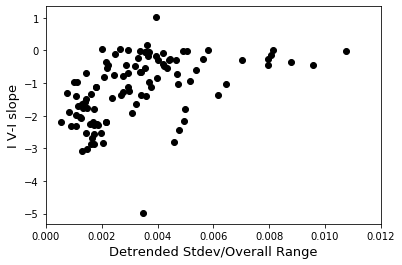

In [126]:
plt.scatter(alls['det stdev/I range'],alls['I V-I slope'],color='black')
plt.xlim(0,.012)
plt.xlabel('Detrended Stdev/Overall Range',fontsize=13)
plt.ylabel('I V-I slope',fontsize=13)

Text(0, 0.5, 'mean abs I vs. V-I residual')

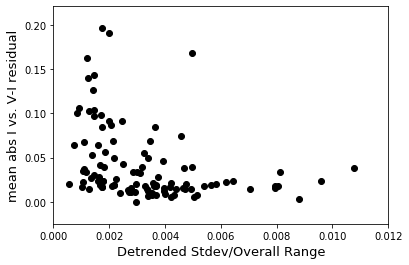

In [134]:
col = 'mean abs I vs. V-I residual'
plt.scatter(alls['det stdev/I range'],alls[col],color='black')
plt.xlim(0,.012)
plt.xlabel('Detrended Stdev/Overall Range',fontsize=13)
plt.ylabel(col,fontsize=13)

(0, 1.5)

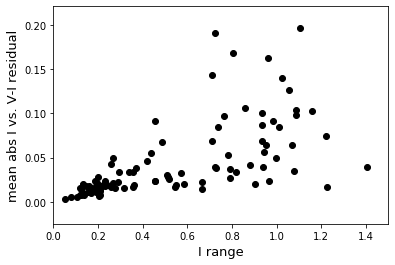

In [145]:
col = 'mean abs I vs. V-I residual'
xcol = 'I range'
plt.scatter(alls[xcol],alls[col],color='black')
plt.xlabel(xcol,fontsize=13)
plt.ylabel(col,fontsize=13)
#taking out outliers but curious about those
plt.xlim(0,1.5)

(0, 0.015)

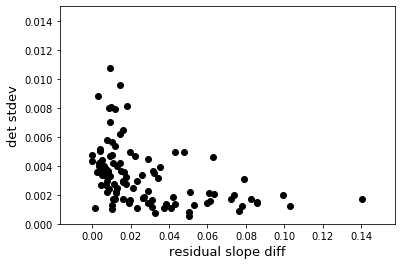

In [164]:
plt.scatter(alls['mean abs bright residual'],alls['det stdev/I range'],color='black')
plt.xlabel('residual slope diff',fontsize=13)
plt.ylabel('det stdev',fontsize=13)
plt.ylim(0,0.015) #comes from Type 1 having low det stdev?

In [ ]:
#write out allsumm csv